# Movie Recommendation System Project  

This project is a **Movie Recommendation System** developed using the **MovieLens** dataset. The system suggests movies based on user preferences and behavior using various machine learning algorithms.

---

## Submitted BY:
- **Jawad Ali Amjad   2022-CS-183**
- **Ali Shan   2022-CS-216**
- **Muhammad Jilani   2022-CS-192**

## Instructor:  
**Mam Amna Zafar**  

---  

## 1. Project Objective

In today's digital world, entertainment websites and online stores host millions of items, making it challenging for users to find the right one. Recommender systems play a crucial role by simplifying this process and helping users discover relevant content quickly.

Our **Movie Recommendation System** aims to utilize machine learning techniques to deliver personalized movie recommendations. This system will be built using **Collaborative Filtering** based on user interactions with the **MovieLens** dataset.

1. **Develop a Collaborative Filtering-based Movie Recommendation System.**  
2. **Predict user ratings for movies they have not rated yet.**  
3. **Minimize the error between predicted and actual ratings using metrics like RMSE and MAPE.**

This system will enhance user experience by dynamically suggesting relevant movies, similar to recommendation engines used by industry leaders such as Netflix and Amazon.

## 2. Data Collection

The dataset for this project has been obtained from **GroupLens**.

**Dataset Link:** [MovieLens 20M Dataset](https://grouplens.org/datasets/movielens/20m/)  

This dataset (**ml-20m**) contains **5-star ratings** and **free-text tagging** activity from **MovieLens**, a popular movie recommendation service. It includes:  
- **20,000,263 ratings**  
- **465,564 tag applications**  
- Across **27,278 movies**  
- Created by **138,493 users** between **January 09, 1995** and **March 31, 2015**  
- Dataset generation date: **October 17, 2016**  

Users in this dataset were randomly selected, with each user having rated at least **20 movies**. No demographic information is included—each user is represented by an ID with no other identifiable details.

The dataset includes the following files:  
- **genome-scores.csv**  
- **genome-tags.csv**  
- **links.csv**  
- **movies.csv**  
- **ratings.csv**  
- **tags.csv**  

### Files Used for Our Objective:  
- **ratings.csv**: Contains user ratings for different movies.  
- **movies.csv**: Contains movie details like titles and genres.  

These files will be used to build and train our **Collaborative Filtering-based Movie Recommendation System**.




In [1]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [3]:
# !pip install fuzzywuzzy
# !pip install scikit-surprise

In [4]:
from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset, SVD, SVDpp, BaselineOnly, KNNBaseline, SlopeOne
from surprise.model_selection import GridSearchCV

In [5]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## 3. Data Preparation and Preprocessing

We will load and explore the dataset to understand its structure and contents. This will help us get the data ready for **Machine Learning (ML)** modeling.

We are doing this to:  
- Remove any missing or unnecessary data.  
- Fix any incorrect data types.  
- Filter the data we need for Collaborative Filtering.  
- Combine **ratings.csv** and **movies.csv** to create a single dataset for training.

This will make the data clean and organized, so we can build an accurate Movie Recommendation System.


In [6]:
# Loading the dataset

file_path = r"F:\IDS Project\Data Set\ml-20m"

movie_ratings = pd.read_csv(file_path + "/ratings.csv")
movies = pd.read_csv(file_path + "/movies.csv")

In [7]:
# Creating a newId for every movie to reduce the range of existing movieId

movies["newId"] = range(1, movies["movieId"].nunique()+1)

In [8]:
# Converting the the UTC timestamp to Datetime
movie_ratings["timestamp"] = movie_ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
movie_ratings["movieId"] = movie_ratings["newId"]
movies["movieId"] = movies["newId"]

In [9]:
# Dropping the newId from the datasets
movie_ratings.drop(["newId"], axis=1, inplace=True)
movies.drop(["newId"], axis=1, inplace=True)

# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)

In [10]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()

The number of records are :  20000263
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


Observations

- The dataset contains **over 20 million records**.  
- There are **6 key features** in the combined dataset:  
  1. **userId**: Unique identifier for each user.  
  2. **movieId**: Unique identifier for each movie.  
  3. **rating**: The user's rating for a movie (on a 5-star scale).  
  4. **date**: The date when the rating was given.  
  5. **title**: The name of the movie.  
  6. **genres**: The genres associated with the movie.  

## 3.1 Data Cleaning

We will clean the data by handling missing values, removing outliers, and dealing with rare values. We will also drop unnecessary features that do not provide useful information.


In [11]:
# Checking for duplicates

print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


Observations:

There are no duplicate records in the dataset.

In [12]:

# Checking the columns' titles and datatypes

movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


### 3.1.1 Handling Missing Values
Identifying the features that have some missing values and imputing them.

In [13]:
# Checking the number of missing values in data

movie_ratings.isna().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
dtype: int64

Observations:

It looks like that the dataset is well maintained as we do not see any missing values, which is good.

## 3.2 Exploratory Data Analysis
After the data cleaning steps, we can now perform EDA on the dataset to discover patterns and relationships that will help in understanding the data better.


### 3.2.1 Univariate Analysis
Analyzing each feature inidividually to gain insights from the data and discover any outliers.

In [14]:
# Checking the feature "userID"

total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  138493
The top 5 userID in the dataset are : 
 userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: count, dtype: int64


In [15]:
# Checking the feature "movieID"

total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  26744
The top 5 movieID in the dataset are : 
 movieId
294    67310
353    66172
316    63366
588    63299
477    59715
Name: count, dtype: int64


Observations

- **userId** represents users selected at random, and their IDs have been anonymized.  
- There are **138K+ unique users** in the dataset.  
- **userId 118205** has around **9K records** in the dataset.


In [16]:
# Helper function to Change the numeric label in terms of Millions

def changingLabels(number):

    return str(number/10**6) + "M"

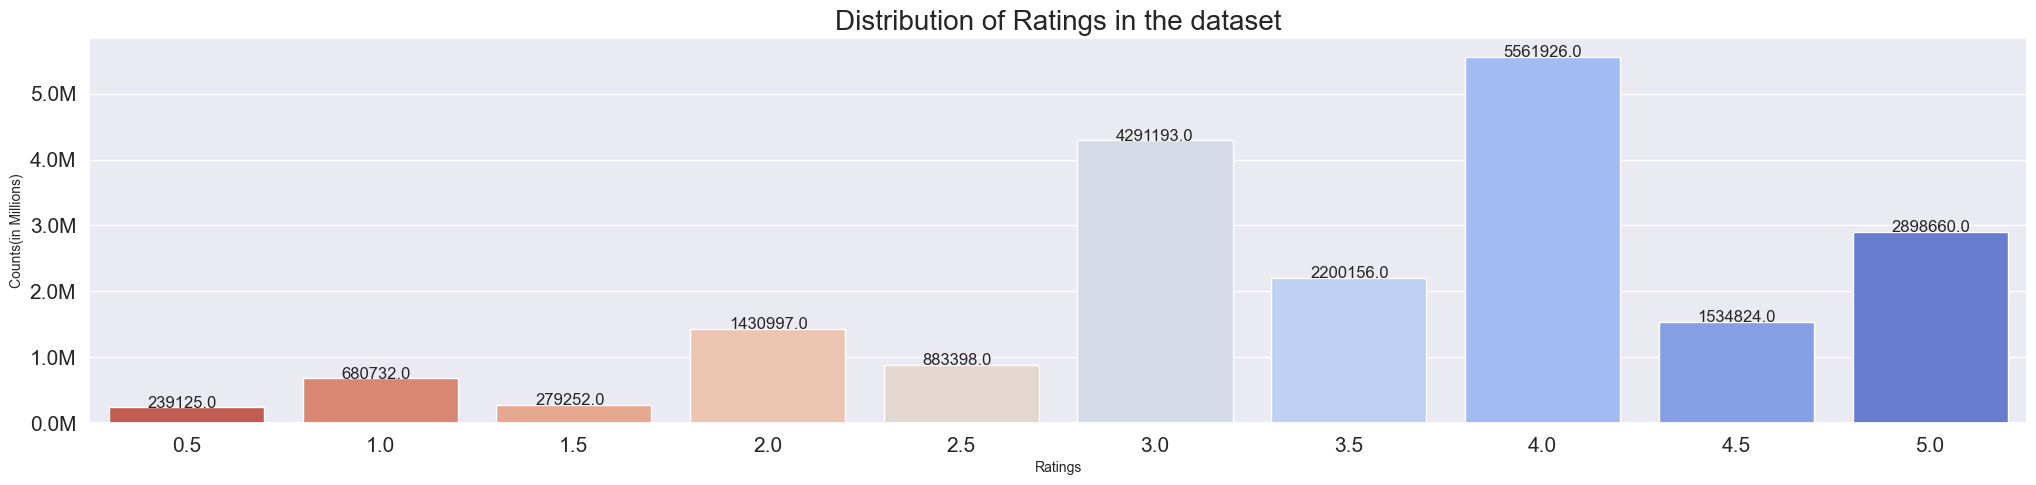

In [17]:
# Checking the feature "rating"

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=movie_ratings, ax=axes, palette="coolwarm_r")
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

Observations

- The ratings given by users range from **0.5 to 5**.  
- A large proportion of the movies have been rated **3**, **3.5**, or **4** by users.  
- The distribution of ratings is **left skewed**, with most ratings falling between **3 to 5**.


In [18]:
# Checking the feature "date"

print("The count of unique date in the dataset is : ", movie_ratings["date"].nunique())
print("The first rating was given on : ", movie_ratings["date"].min())
print("The latest rating was given on : ", movie_ratings["date"].max())
print("The top 5 date in the dataset are : \n", movie_ratings["date"].value_counts()[:5])

The count of unique date in the dataset is :  6911
The first rating was given on :  1995-01-09
The latest rating was given on :  2015-03-31
The top 5 date in the dataset are : 
 date
2000-11-20    91753
2005-03-22    76568
1999-12-11    65077
2008-10-29    55163
2000-11-21    54131
Name: count, dtype: int64


Observations

- There are approximately **7K unique dates** when users rated movies.  
- The first rating was given on **1995-01-09**, and the latest rating was given on **2015-03-31**.  
- Around **91K+ ratings** were recorded on **2000-11-20**.

In [19]:
movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  26729
The top 5 title in the dataset are : 
 title
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: count, dtype: int64


Observations

- There are over **26K unique movie titles** in the dataset.  
- The top 4 movies with the most ratings are:  
  1. **Pulp Fiction**  
  2. **Forrest Gump**  
  3. **Shawshank Redemption**  
  4. **Silence of the Lambs**  
  Each of these movies has received over **60K ratings**.


In [20]:
# Extract unique Genres along with their count

unique_genres = {}

def ExtractGenres(x):
    for g in x.split("|"):
        if g not in unique_genres.keys():
            unique_genres[g] = 1
        else:
            unique_genres[g] = unique_genres[g] + 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres Extracted from the dataset.")

Genres Extracted from the dataset.


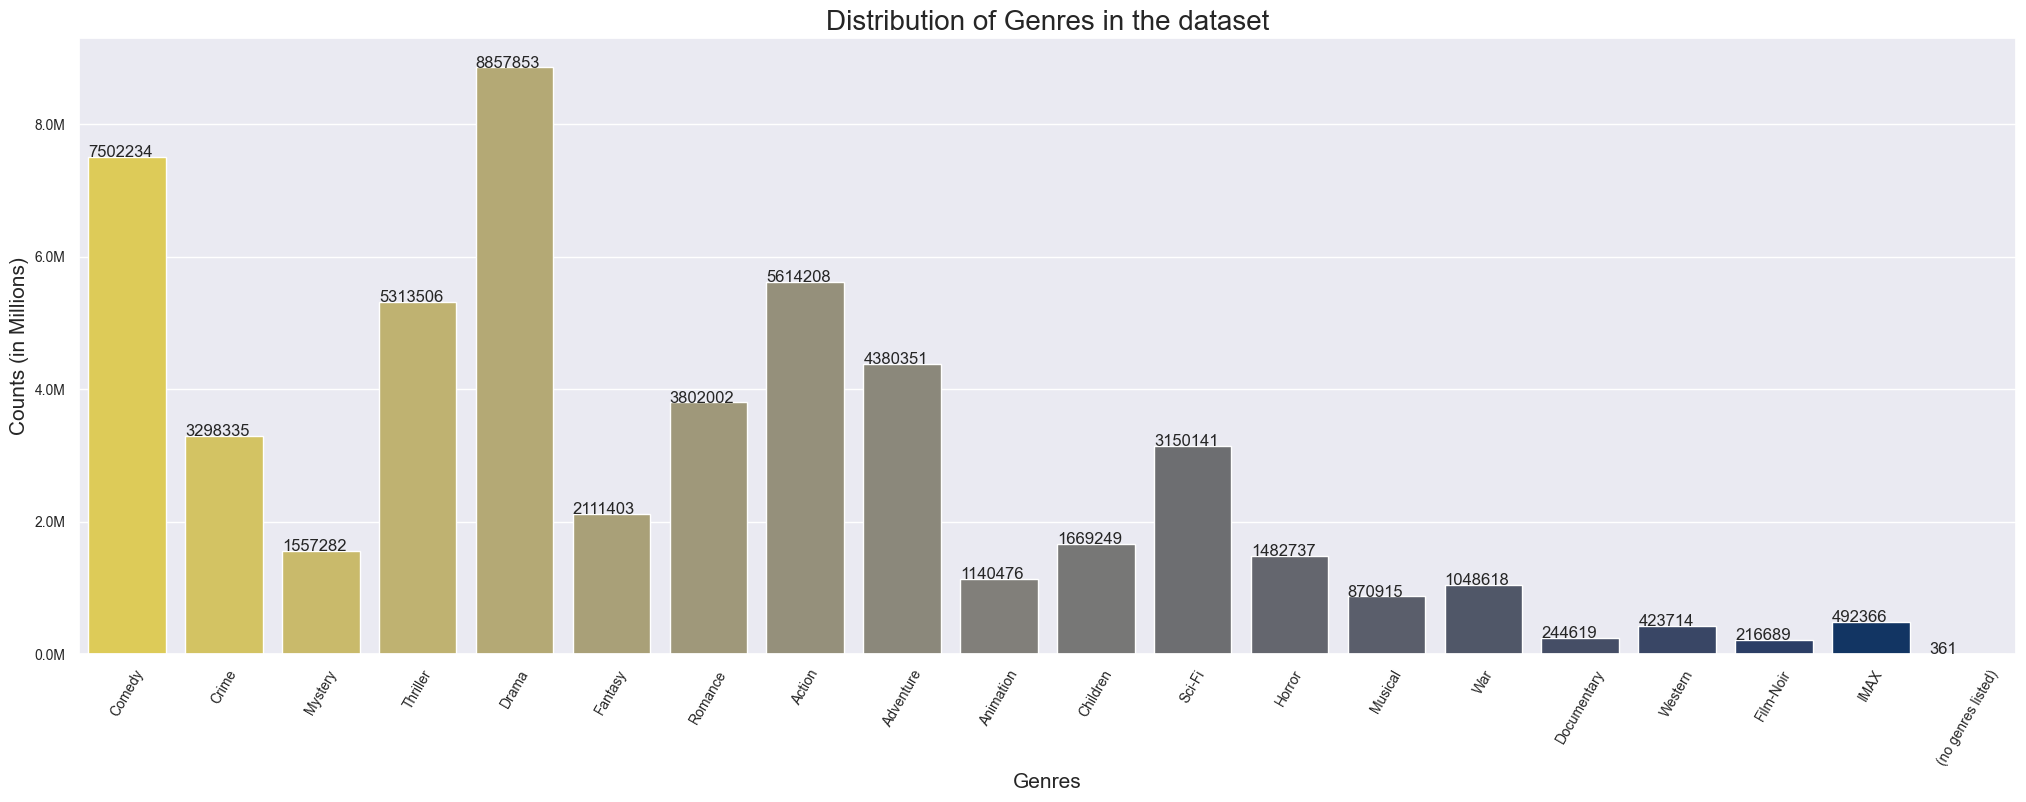

In [21]:
# Visualizing the feature "Genres"

genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"]

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes, palette="cividis_r")
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Observations

- There are **19 different genres** of movies, although some movies have no genre listed.  
- The top 4 genres in the dataset are:  
  1. **Drama**  
  2. **Comedy**  
  3. **Action**  
  4. **Thriller**


In [22]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


### 3.2.2 Train & test Splitting
Splitting the data into train and test sets before proceeding towards further EDA and Feature Engineering.

In [23]:
# Creating the train test set

file_path = r"F:\IDS Project\Data Set\ml-20m"

if not os.path.isfile(file_path + "/TrainData.pkl"):
    print("Creating Train Data and saving it..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle(file_path + "/TrainData.pkl")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Train Data..")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile(file_path + "/TestData.pkl"):
    print("Creating Test Data and saving it..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle(file_path + "/TestData.pkl")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Test Data..")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

Loading Train Data..
Loading Test Data..


In [24]:
Train_Data.head()

,userId,movieId,rating,date,title,genres
0,131160,1058,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
1,131160,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,131160,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
4,85252,7,5.0,1996-01-29,Sabrina (1995),Comedy|Romance


In [25]:
# Creating list of unique movies from Train Set

movie_list_in_training = Train_Data.drop_duplicates(subset=["title"], keep="first")[["movieId", "title", "genres"]]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

,movieId,title,genres
0,1058,"Fish Called Wanda, A (1988)",Comedy|Crime
1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,1154,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,21,Get Shorty (1995),Comedy|Crime|Thriller
4,7,Sabrina (1995),Comedy|Romance


In [26]:
# Checking the basic statistics for the training data

print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

Total Train Data..
Total number of movie ratings in train data :  16000210
Number of unique users in train data :  112466
Number of unique movies in train data :  12387


### 3.2.3 Bi-variate Analysis
Analyzing multiple features together to discover relations, correlations and patterns.

In [27]:
# Checking basic statistics for "rating"

print("The basic statistics for the feature is : \n", Train_Data["rating"].describe())

The basic statistics for the feature is : 
 count    1.600021e+07
mean     3.512613e+00
std      1.059931e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


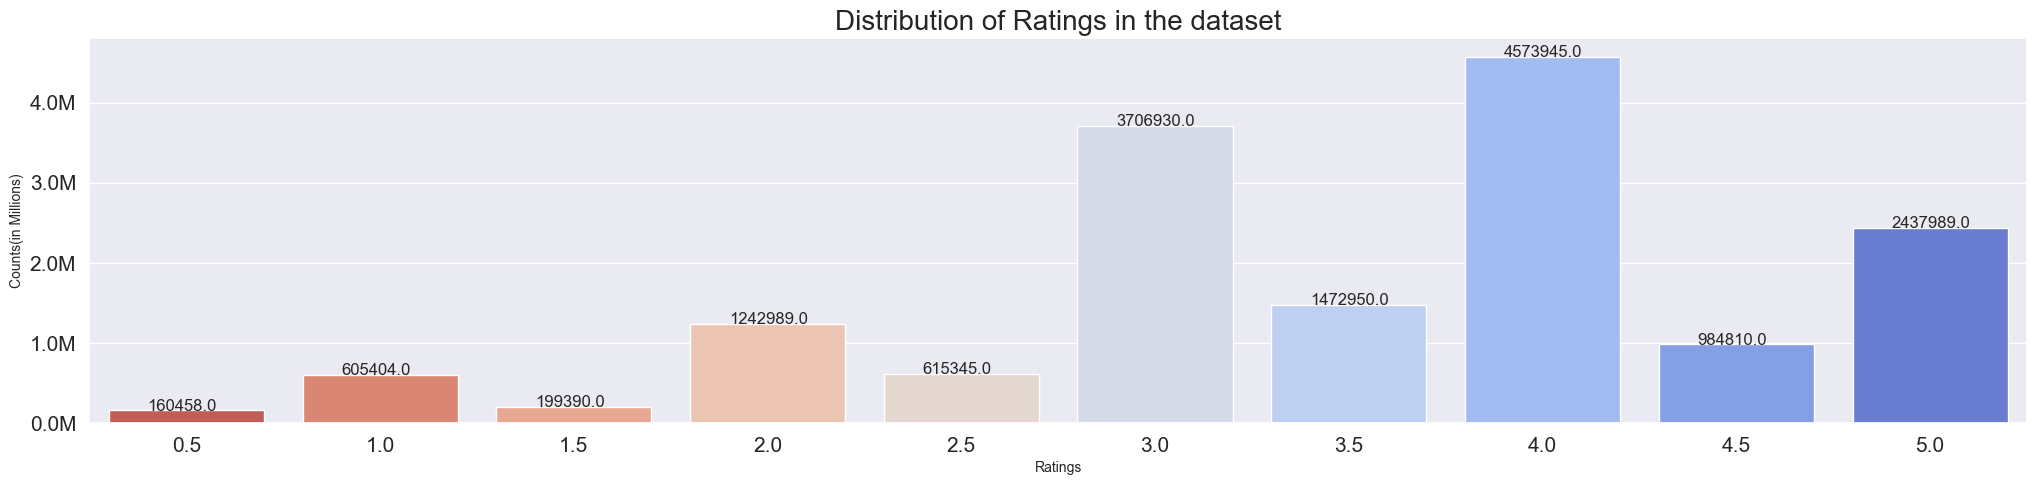

In [28]:
# Visualizing the "rating" for the train set

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=Train_Data, ax=axes, palette="coolwarm_r")
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

Observations

- The distribution of ratings appears similar to previous observations.  
- The **mean** and **median** values are both around **3.5**.


In [29]:
# Extracting the day of week from the date when rating was provided

Train_Data["date"] = pd.to_datetime(Train_Data["date"], errors='coerce')
Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime('%A')
Train_Data["Weekday"] = Train_Data["date"].apply(lambda x : 1 if x.dayofweek >= 5 else 0)

In [30]:
def ChangingLabelsInK(number):
    return f"{number // 1000}K" if number >= 1000 else str(number)

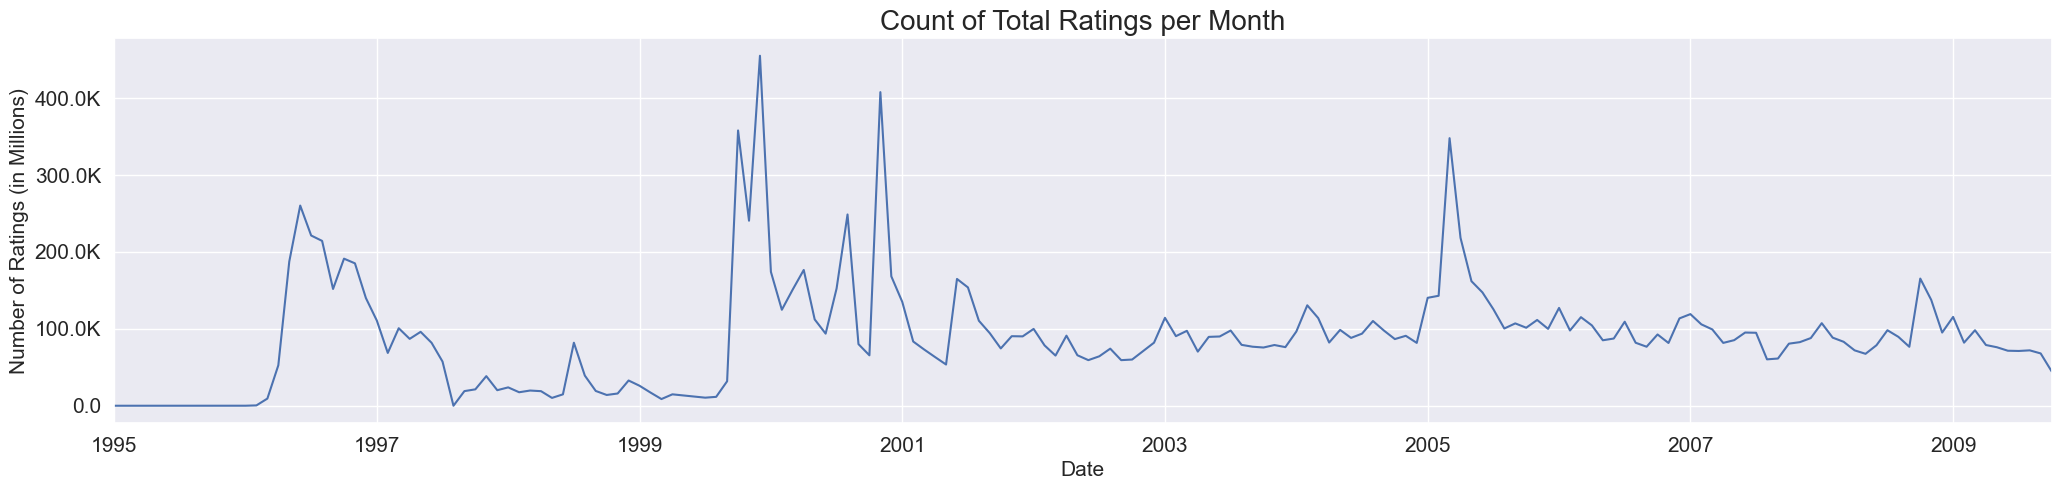

In [31]:
# Visualizing the count of total ratings made per month

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
axes = Train_Data.resample("m", on = "date")["rating"].count().plot()

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in Millions)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

Observations

- The number of ratings per month was very high in several months between **1996 and 1998**.  
- After the 2000s, there were a few months with a significantly high number of ratings.  
- The count remained steady from **2001 to 2010**, with a spike in ratings during a few months of **2006**.


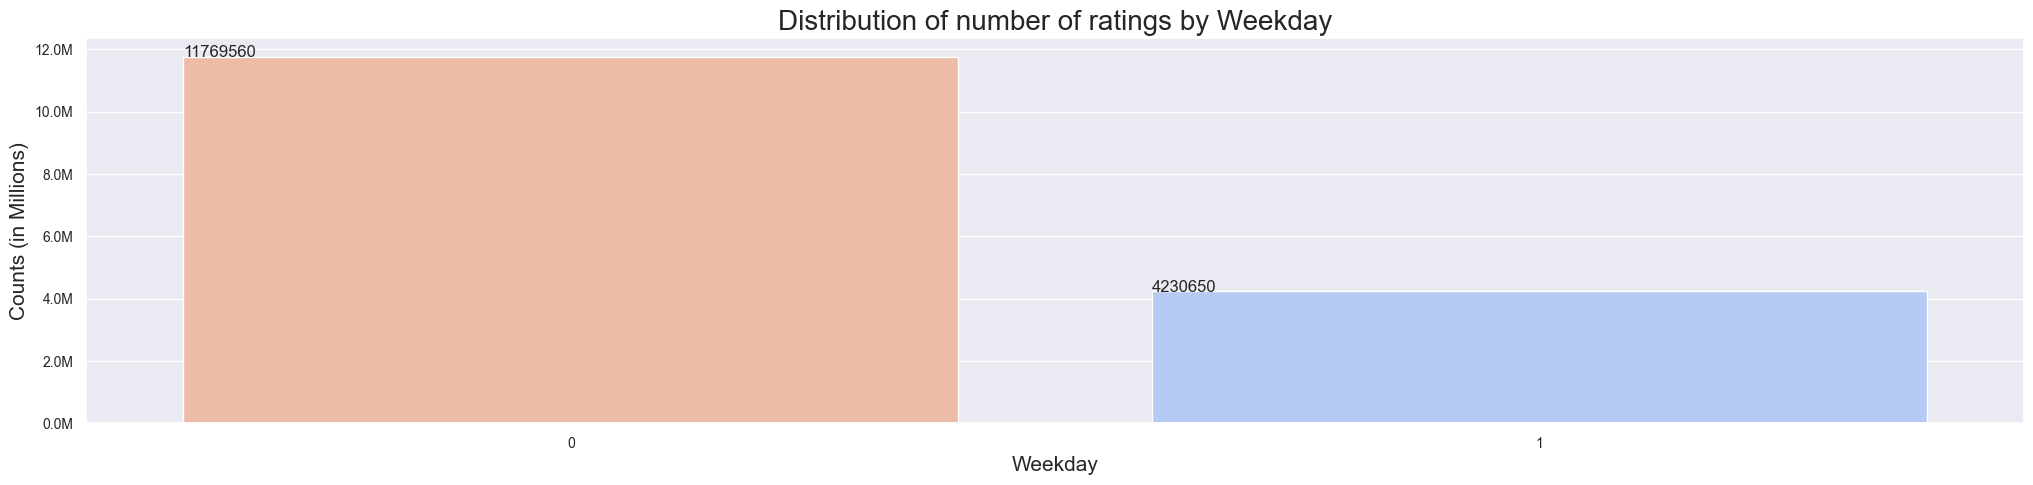

In [32]:
# Visualizing the count of ratings by weekday

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="Weekday", y="rating" , data=Train_Data.groupby(by=["Weekday"], as_index=False)["rating"].count(), ax=axes, palette="coolwarm_r")
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

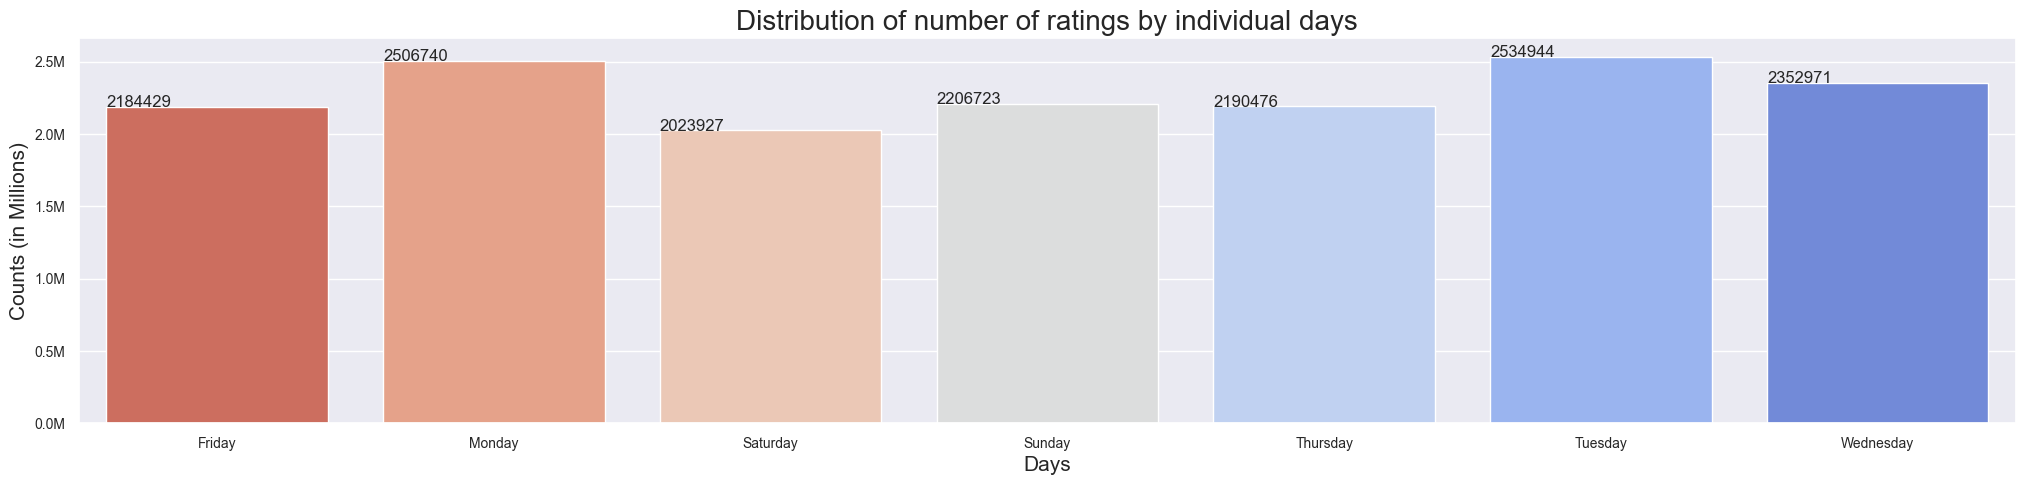

In [33]:
# Visualizing the count of ratings by individual days of the week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="DayOfWeek", y="rating" , data=Train_Data.groupby(by=["DayOfWeek"], as_index=False)["rating"].count(), ax=axes, palette="coolwarm_r")
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by individual days", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Observations:

1. The no. of ratings does not vary too much the days of the week.2.
2. "Monday" and "Tuesday" clearly has more no. of ratings than any other days.
3. The number of ratings in weekend is clearly extremly less than weekdays.

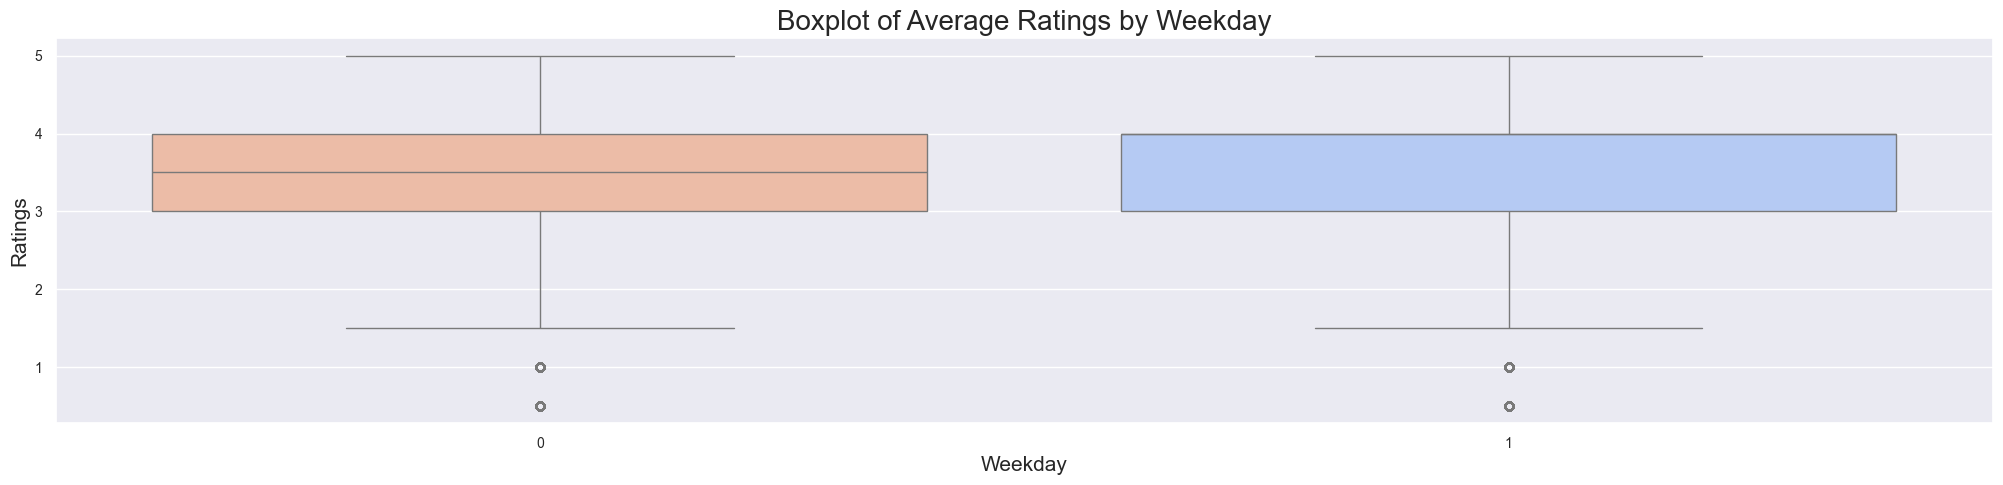

In [34]:
# Visualizing the average ratings by weekday

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="Weekday", y="rating" , data=Train_Data, ax=axes, palette="coolwarm_r")

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

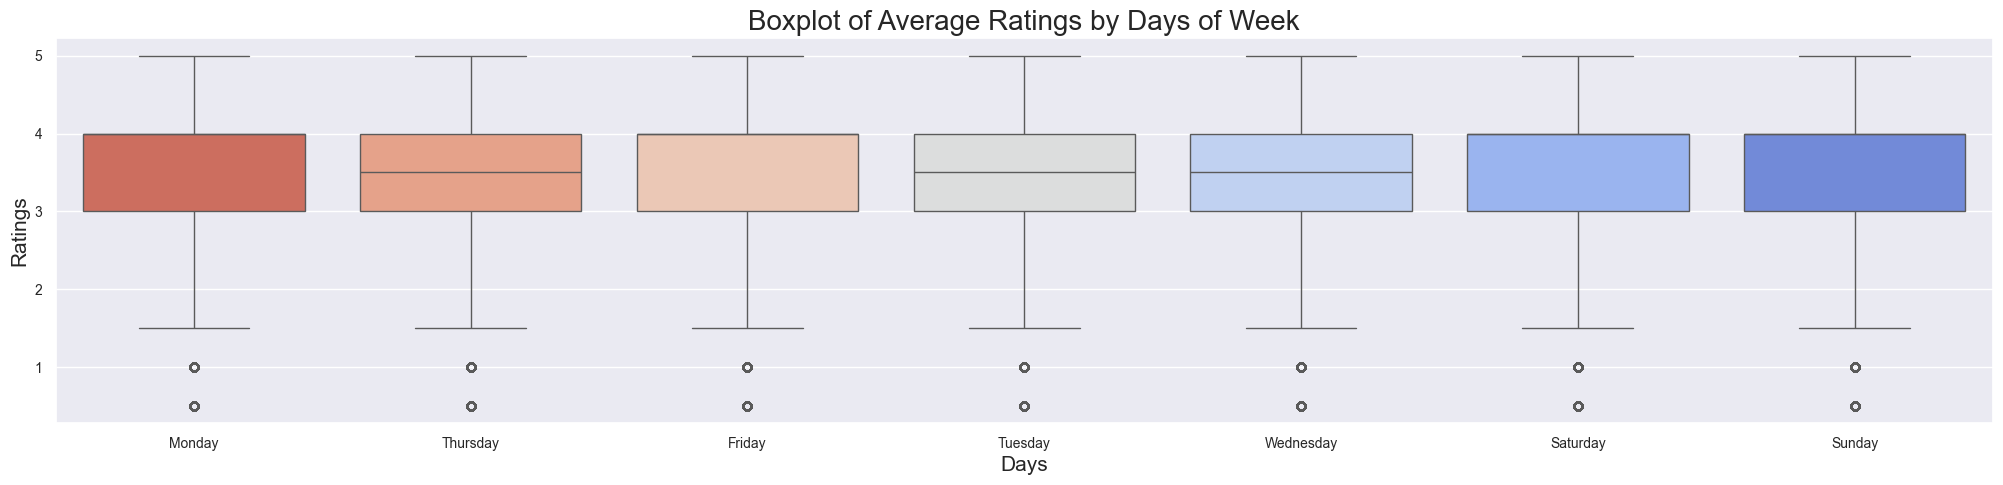

In [35]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="DayOfWeek", y="rating", data=Train_Data, ax=axes, palette="coolwarm_r")

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Days of Week", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

Observations:

1. The average ratings given by the user does not seem to differ by weekday and weekends.
2. Even when we plot the average ratings by individual days, they seem to be similar for all the individual days.

In [36]:
# Calculating the number of ratings given by individual users

no_of_rated_movies_per_user = Train_Data.groupby(by=["userId"], as_index=False)["rating"].count().sort_values(by="rating", ascending=False)
no_of_rated_movies_per_user.reset_index(drop=True, inplace=True)

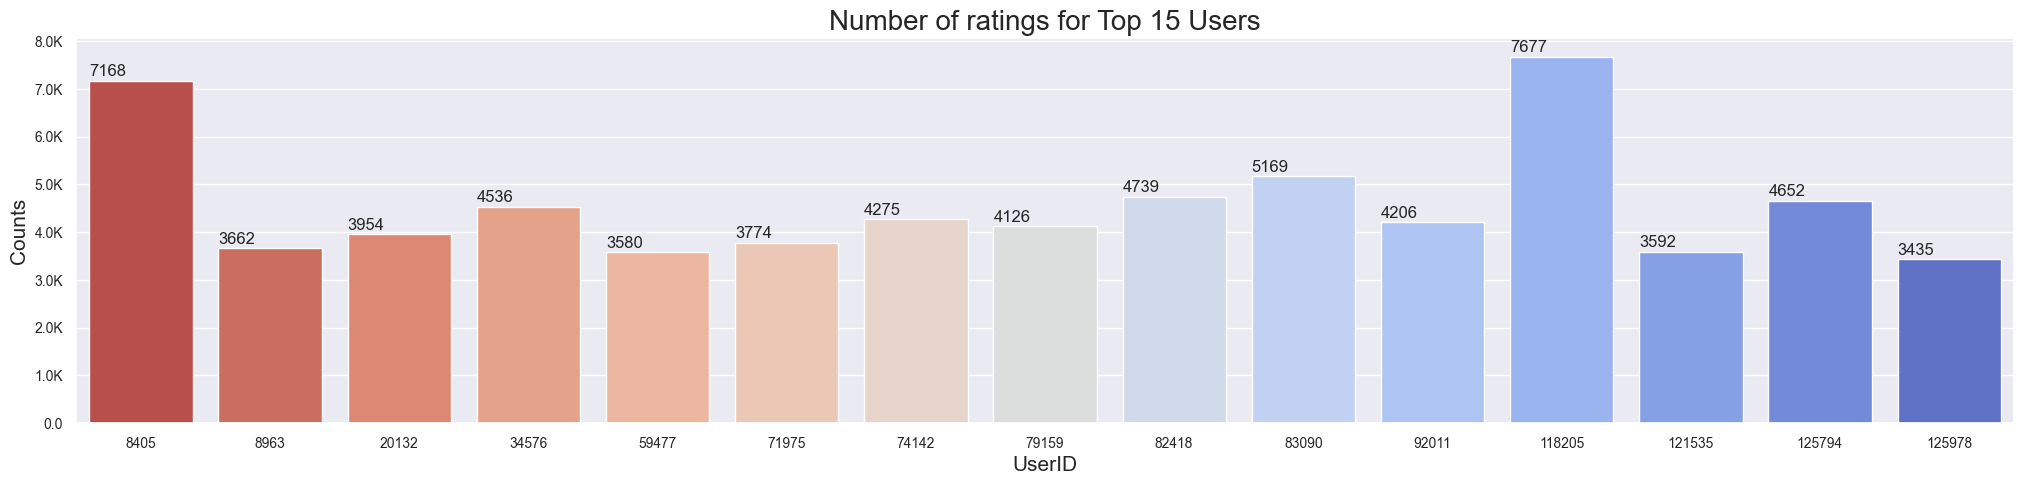

In [37]:
# Visualizing the count of ratings by individual users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="rating" , data=no_of_rated_movies_per_user[:15], ax=axes, palette="coolwarm_r")
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Users", fontsize = 20)
plt.xlabel("UserID", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.show()

In [38]:
# Checking the basic statistics for the number of ratings per user

print("Information about no. of ratings by users : \n", no_of_rated_movies_per_user["rating"].describe())

Information about no. of ratings by users : 
 count    112466.000000
mean        142.267085
std         214.808118
min           1.000000
25%          35.000000
50%          69.000000
75%         155.000000
max        7677.000000
Name: rating, dtype: float64


In [39]:
quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0.9, 1.01,0.01))
qvalue = np.arange(0.9, 1.01,0.01)
for ctr in qvalue:
    print("The {}th quantile value is : {}".format(int(ctr*100), quantiles[ctr]))

The 90th quantile value is : 333.0
The 91th quantile value is : 358.0
The 92th quantile value is : 386.0
The 93th quantile value is : 418.0
The 94th quantile value is : 459.0
The 95th quantile value is : 510.0
The 96th quantile value is : 573.0
The 97th quantile value is : 664.0
The 98th quantile value is : 804.7000000000116
The 99th quantile value is : 1060.3500000000058
The 100th quantile value is : 7677.0


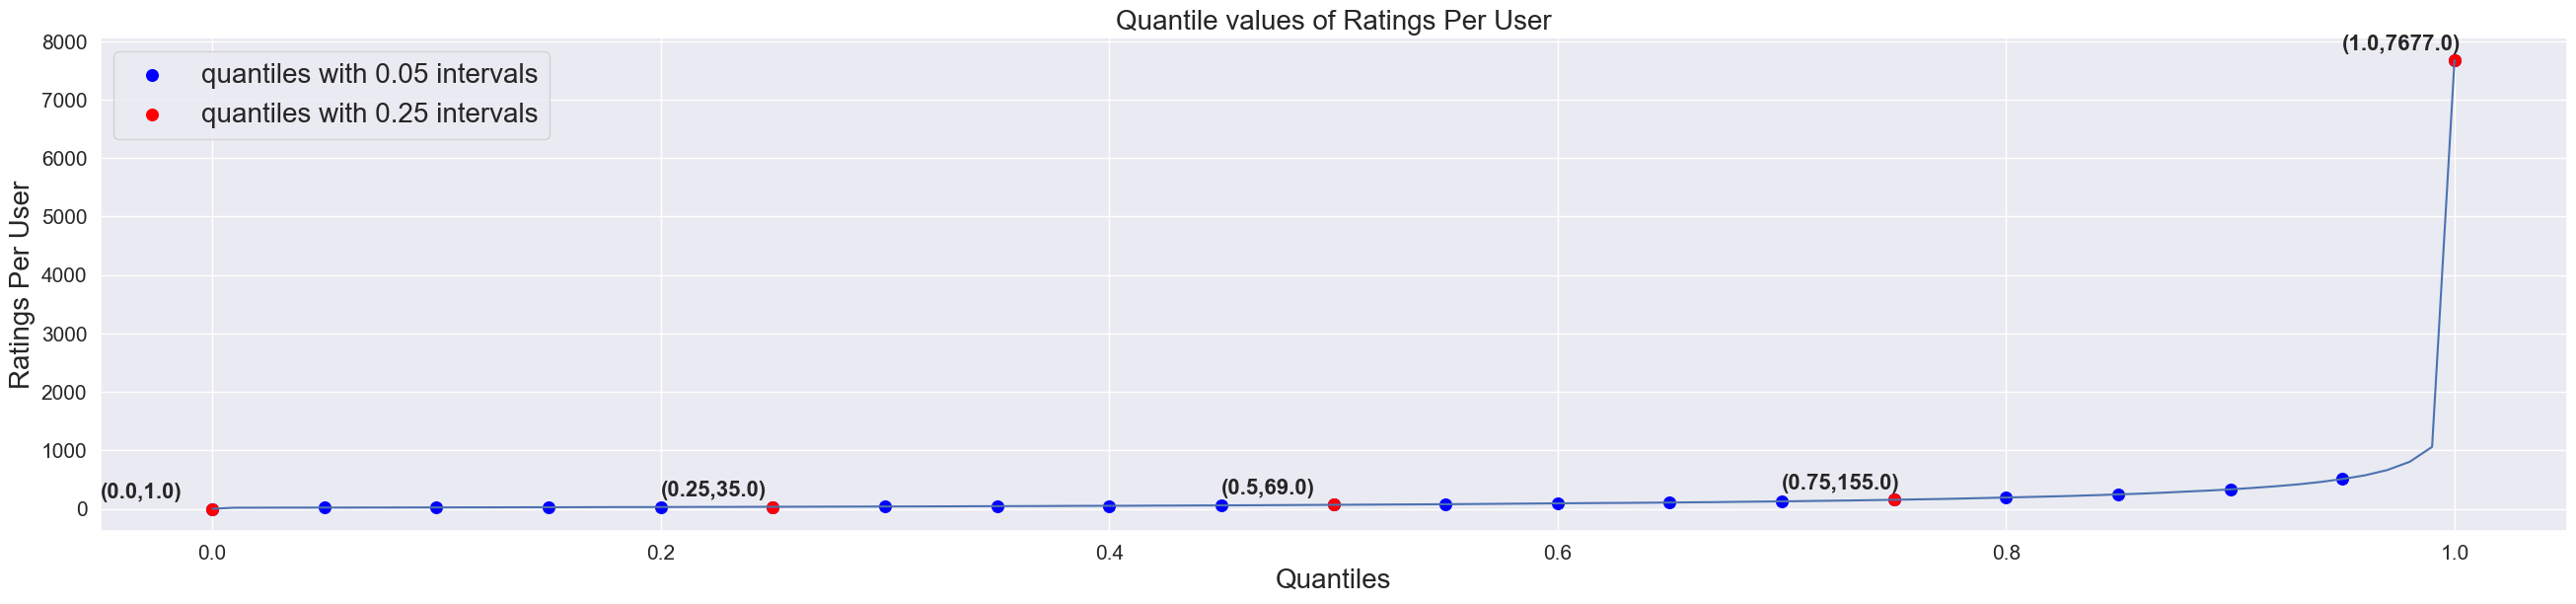

In [40]:
# Plotting the quantile values

quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0, 1.01, 0.01))

fig = plt.figure(figsize=(25, 5))

axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile values of Ratings Per User", fontsize=20)
axes.set_xlabel("Quantiles", fontsize=20)
axes.set_ylabel("Ratings Per User", fontsize=20)
axes.plot(quantiles)

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c="blue", s=70, label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c="red", s=70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize=20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate('({},{})'.format(x, y), xy=(x, y), fontweight='bold', fontsize=16, xytext=(x - 0.05, y + 180))

axes.tick_params(labelsize=15)
plt.show()

Observations:

1. The top 10 users tend to have rated more than 4K times, which seems bit extreme behaviour.
2. The userId 118205 has rated over 7K+ times, which seems surprising.
3. From the KDE plot, it is clearly evident that the number of ratings is highly right skewed, and most of the user's ratings is between 0-1000.
4. Similarly, above CDF graph shows that almost 99% of users give very few ratings.
5. The mean no. of ratings a user gives is 142 while the median is 69.
6. The no. of movies start to increase drastically from 90th percentile.

In [41]:
# Calculating average ratings given by individual users

avg_ratings_per_user = Train_Data.groupby(by = ["userId"], as_index=False)["rating"].mean()
avg_ratings_per_user = avg_ratings_per_user.reset_index(drop=True)
avg_ratings_per_user = avg_ratings_per_user.merge(no_of_rated_movies_per_user[["userId", "rating"]], how="left", on="userId")
avg_ratings_per_user.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_user = avg_ratings_per_user.sort_values("num_of_rating", ascending=False)

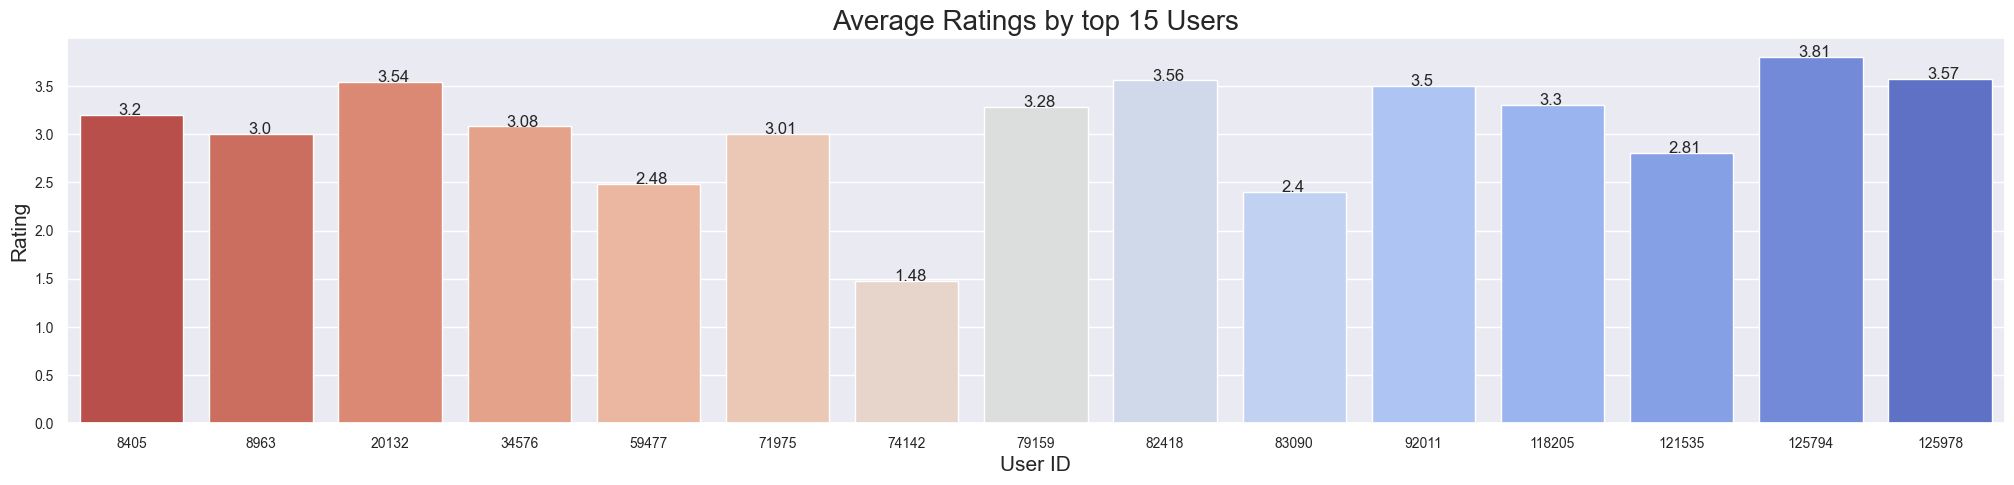

In [42]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="avg_rating", data=avg_ratings_per_user[:15], ax=axes, palette="coolwarm_r")

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings by top 15 Users", fontsize = 20)
plt.xlabel("User ID", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [43]:
# Calculating count of ratings received for movies

no_of_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].count().sort_values(by=["rating"], ascending = False)
no_of_ratings_per_movie = no_of_ratings_per_movie.reset_index(drop=True)

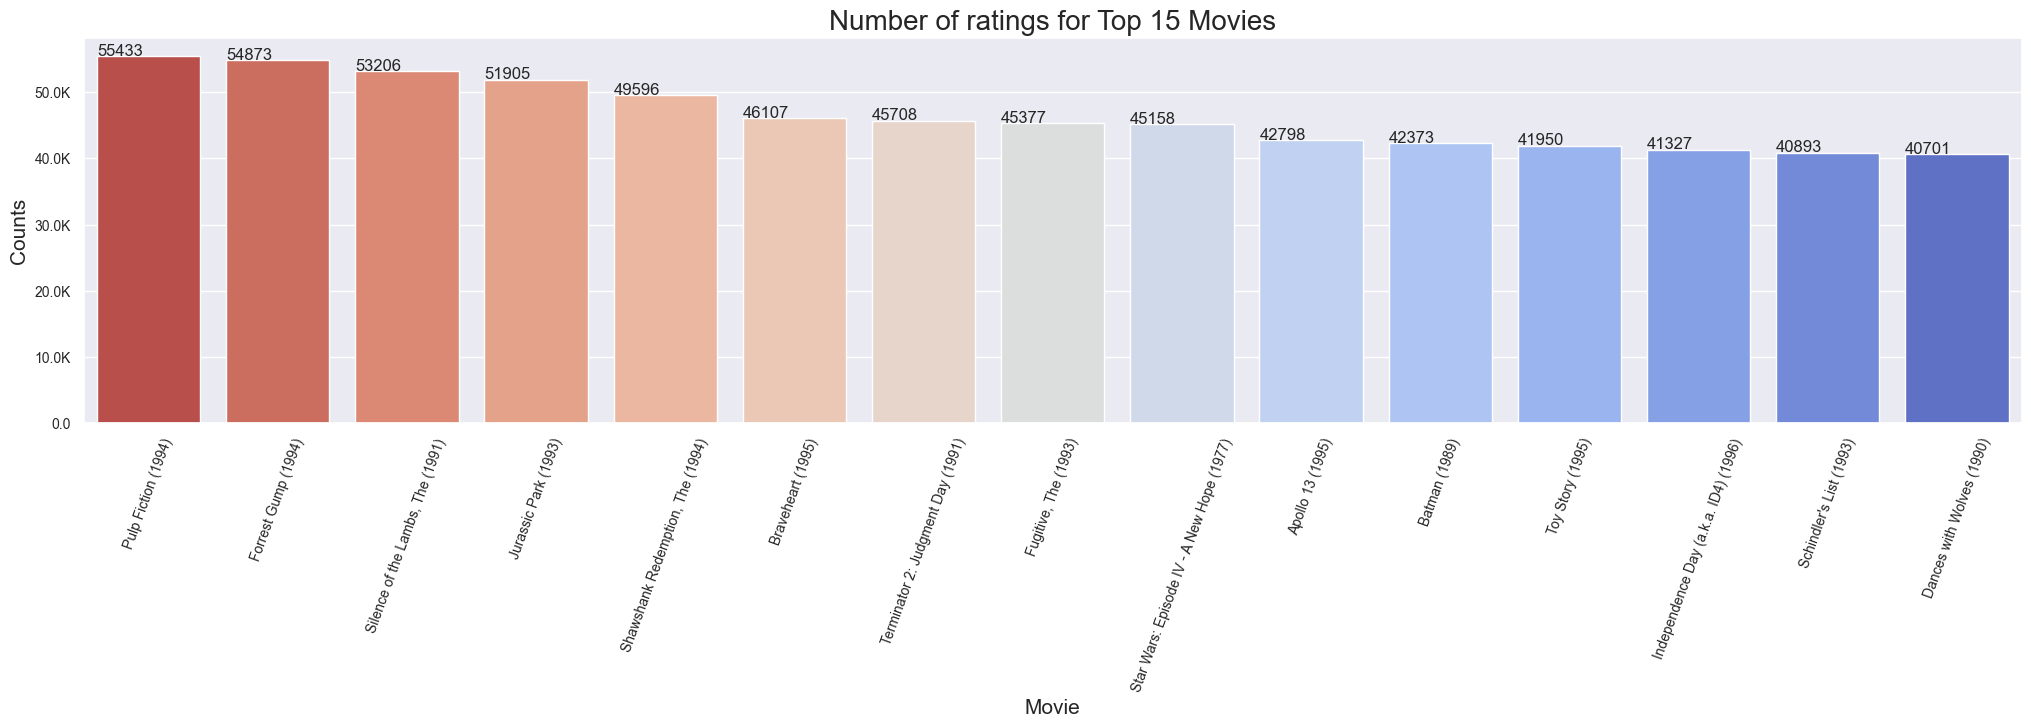

In [44]:
# Visualizing top 15 movies heavily rated movies.

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="rating", data=no_of_ratings_per_movie[:15], ax=axes, palette="coolwarm_r")
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Movies", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [45]:
# Calculating average ratings for movies

avg_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].mean()
avg_ratings_per_movie = avg_ratings_per_movie.reset_index(drop=True)
avg_ratings_per_movie = avg_ratings_per_movie.merge(no_of_ratings_per_movie[["movieId", "rating"]], how="left", on="movieId")
avg_ratings_per_movie.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_movie = avg_ratings_per_movie.sort_values("num_of_rating", ascending=False)

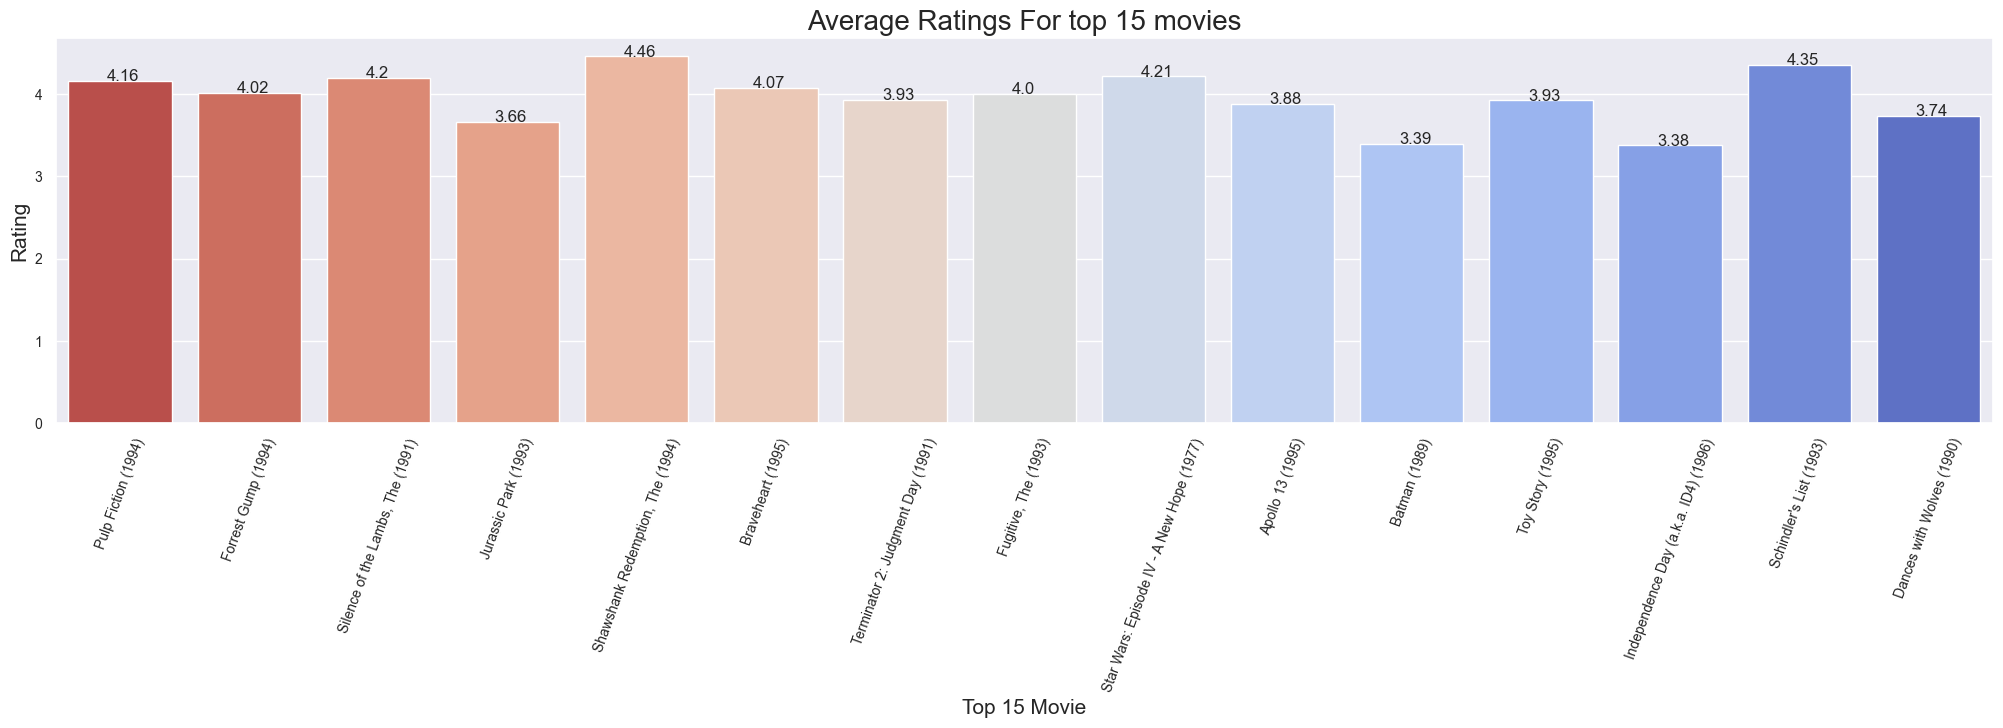

In [46]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="avg_rating", data=avg_ratings_per_movie[:15], ax=axes, palette="coolwarm_r")

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings For top 15 movies", fontsize = 20)
plt.xlabel("Top 15 Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

Observations:

1. The cult movies form 1990s have been rated the most.
2. Pulp Fiction, Forrest Gump, Shawshank Redemption and Silience of the Lambs have been rated over 50K times.
3. Shawshank Redemption has the highest average rating of 4.56 based on 50K+ ratings.

## 3.3. Feature Engineering
Now that we have completed the data exploration part, we can start the Feature Engineering in order to prepare the data for the ML algorithms.

In [47]:
# Path for loading/saving files

file_path = "F:\IDS Project"

In [48]:
# Creating/loading user-movie sparse matrix for train data

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for train Data..")

if os.path.isfile(file_path + "/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz(file_path + "/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))    
else:
    print("We are creating sparse data..")
    TrainUISparseData = sparse.csr_matrix((Train_Data.rating, (Train_Data.userId, Train_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print("Time taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data..
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix


Shape of Train Sparse matrix = (138494, 14334)
Time taken :  0:00:02.504314


In [50]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.19401432357586% 


In [51]:
# Creating/loading user-movie sparse matrix for test data

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for test Data..")

if os.path.isfile(file_path + "/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz(file_path + "/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix : ", str(TestUISparseData.shape))
else:
    print("We are creating sparse data..")
    TestUISparseData = sparse.csr_matrix((Test_Data.rating, (Test_Data.userId, Test_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print("Time Taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data..
We are creating sparse data..
Creation done. Shape of sparse matrix :  (138494, 27279)
Saving it into disk for furthur usage.
Done

Time Taken :  0:00:07.293863


In [52]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.89412185078294% 


In [53]:
# Function to Calculate Average rating for users or movies from User-movie sparse matrix
 
def getAverageRatings(sparseMatrix, if_user):

    #axis = 1 means rows and axis = 0 means columns 
    ax = 1 if if_user else 0

    sumOfRatings = sparseMatrix.sum(axis = ax).A1  
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    
    return averageRatings

In [54]:

AvgRatingUser = getAverageRatings(TrainUISparseData, True)
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users : ", total_users)
print("No. of Users in Train data : ", train_users)
print("No. of Users not present in Train data : {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users :  138493
No. of Users in Train data :  112466
No. of Users not present in Train data : 26027(19.0%)


In [55]:

train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies : ", total_movies)
print("No. of Movies in Train data : ", train_movies)
print("No. of Movies not present in Train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies :  26744
No. of Movies in Train data :  12387
No. of Movies not present in Train data = 14357(54.0%)


In [56]:
# Computing user-user similarity matrix for the train data
# We have 138K sized sparse vectors using which a 14K x 14K movie similarity matrix would be calculated

start = datetime.now()

if not os.path.isfile(file_path + "/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Dimension of Matrix : ", m_m_similarity.shape)
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz(file_path + "/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz(file_path + "/m_m_similarity.npz")
    print("Dimension of Matrix : ", m_m_similarity.shape)
    
print("The time taken to compute movie-movie similarity matrix is : ", datetime.now() - start)

Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...
Dimension of Matrix :  (14334, 14334)
Storing the Movie Similarity matrix on disk for further usage
The time taken to compute movie-movie similarity matrix is :  0:03:35.576431


In [57]:
# Creating a function to take Movie Name and generate the top matched name and generate its N similar movies based on M-M Similary

def GetSimilarMoviesUsingMovieMovieSimilarity(movie_name, num_of_similar_movies):
    matches = process.extract(movie_name, movie_list_in_training["title"], scorer=fuzz.partial_ratio)
    if len(matches) == 0:
        return "No Match Found"
    movie_id = movie_list_in_training.iloc[matches[0][2]]["movieId"]
    similar_movie_id_list = np.argsort(-m_m_similarity[movie_id].toarray().ravel())[0:num_of_similar_movies+1]
    sm_df = movie_list_in_training[movie_list_in_training["movieId"].isin(similar_movie_id_list)]
    sm_df["order"] = sm_df.apply(lambda x: list(similar_movie_id_list).index(x["movieId"]), axis=1)
    
    return sm_df.sort_values("order")

In [59]:
# Picking random movie and checking it's top 10 most similar movies

GetSimilarMoviesUsingMovieMovieSimilarity("Survival", 10)

,movieId,title,genres,order
1268,1291,Kids of Survival (1996),Documentary,0
1330,1280,I Shot a Man in Vegas (1995),Comedy,1
1228,1096,North Star (a.k.a. Tashunga) (1995),Action|Adventure|Crime|Drama|Western,2
1230,1143,"Bloody Child, The (1996)",Drama|Thriller,3
1227,1093,Sleepover (1995),Drama,4
1308,1281,Parallel Sons (1995),Drama|Romance,5
827,841,Every Other Weekend (Un week-end sur deux) (1990),Drama,6
1092,1124,Curtis's Charm (1995),Comedy|Drama,7
1311,1286,Breathing Room (1996),Romance,8
917,858,Shadow of Angels (Schatten der Engel) (1976),Drama,9


In [60]:
# Getting highest uder id

row_index, col_index = TrainUISparseData.nonzero()
unique_user_id = np.unique(row_index)
print("Max User id is :", np.max(unique_user_id))

Max User id is : 138493


Time elapsed for 20 users = 0:00:28.498812sec
Time elapsed for 40 users = 0:00:50.255200sec
Time elapsed for 60 users = 0:01:06.978243sec
Time elapsed for 80 users = 0:01:25.596790sec
Time elapsed for 100 users = 0:01:43.614714sec
Average Time taken to compute similarity matrix for 1 user = 1.0154424834251403seconds


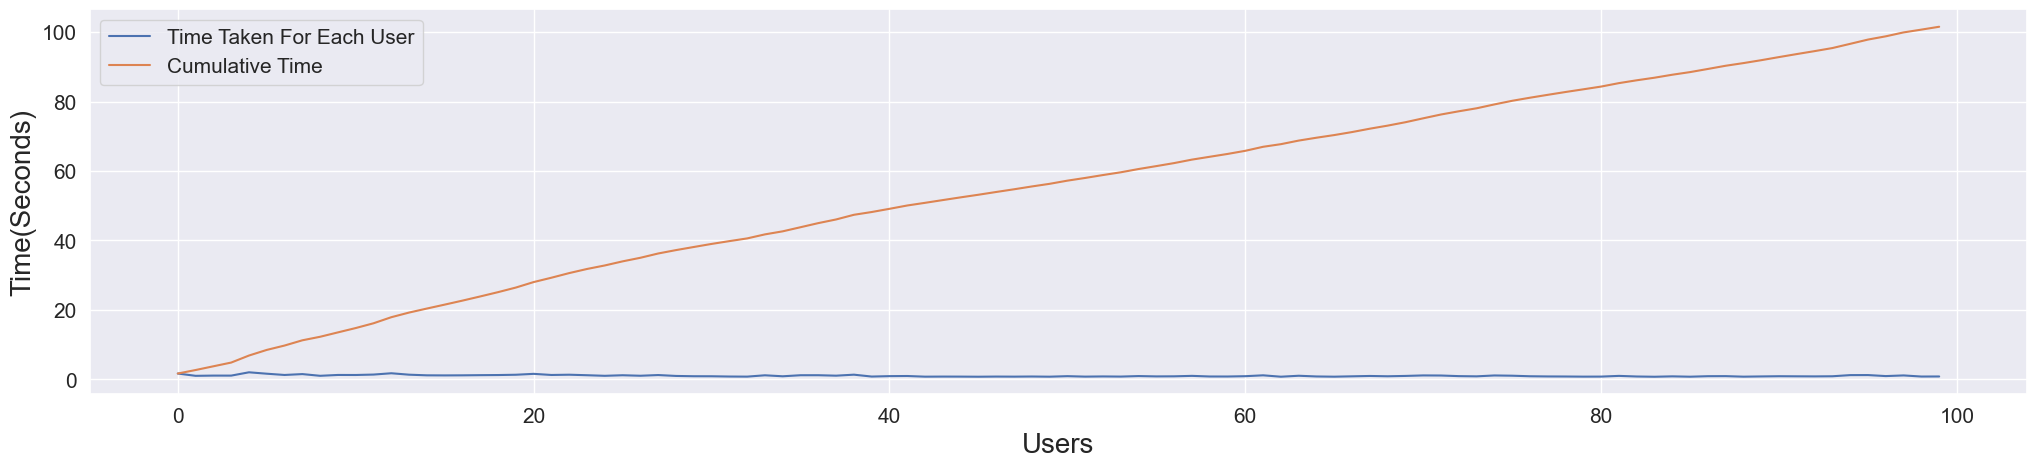

In [61]:
# Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
# Top 100 most similar users with them.

def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()
    rows = np.unique(row_index)
    similarMatrix = np.zeros(13849300).reshape(138493,100)    # 138493*100 = 13849300. As we are building similarity matrix only 
    #for top 100 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)

In [62]:
# Calculating user-user similarity only for particular users in our sparse matrix and return user_ids

def Calculate_User_User_Similarity(sparseMatrix, user_id, num_of_similar_users=10):
    
    if user_id in unique_user_id:
        # Calculating the cosine similarity for user_id with all the "userId"
        sim = cosine_similarity(sparseMatrix.getrow(user_id), sparseMatrix).ravel()
        # Sorting the indexs(user_id) based on the similarity score for all the user ids
        top_similar_user_ids = sim.argsort()[::-1]
        # Sorted the similarity values
        top_similarity_values = sim[top_similar_user_ids]

    return top_similar_user_ids[1: num_of_similar_users+1]

In [63]:
# Getting top 5 users similar to userId: 1

similar_users_1 = Calculate_User_User_Similarity(TrainUISparseData, 1, 5)
similar_users_1

array([81275, 62235,  2595, 75328, 34101], dtype=int64)

In [64]:
file_path = "F:\AI Project"

In [65]:
# Since the given dataset might not completely fit into computaton capacity that we have, we will sample the data and work it

# Function for Sampling random movies and users to reduce the size of rating matrix
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies, matrix_name):

    np.random.seed(15)   #this will give same random number everytime, without replacement
    startTime = datetime.now()

    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)

    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), shape = (max(userS)+1, max(movieS)+1))
 
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(file_path + "/" + matrix_name, sparse_sample)
    print("Shape of Sparse Sampled Matrix = " + str(sparse_sample.shape))    
    print("Time taken : ", datetime.now() - startTime)

    return sparse_sample

In [66]:
# Creating Sample Sparse Matrix for Train Data

if not os.path.isfile(file_path + "/TrainUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 5000, 1000, "TrainUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(file_path + "/TrainUISparseData_Sample.npz")
    print("Shape of Train Sample Sparse Matrix = " + str(train_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Shape of Sparse Sampled Matrix = (138488, 14312)
Time taken :  0:00:18.653734


In [67]:
# Creating Sample Sparse Matrix for Test Data

if not os.path.isfile(file_path + "/TestUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200, "TestUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(file_path + "/TestUISparseData_Sample.npz")
    print("Shape of Test Sample Sparse Matrix = " + str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Shape of Sparse Sampled Matrix = (138456, 27198)
Time taken :  0:00:05.973324


In [68]:
# Checking the shape of Training and test data

print("Shape of Train Sparse Matrix : ", train_sample_sparse.shape)
print("Shape of Test Sparse Matrix : ", test_sample_sparse.shape)

Shape of Train Sparse Matrix :  (138488, 14312)
Shape of Test Sparse Matrix :  (138456, 27198)


In [69]:
# Calculating few GlobalAverageRating, AvgMovieRating, AvgUserRating and TotalNoOfRatings

globalAvgRating = np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Global average of all movies ratings in Train Set is : ", globalAvgRating)
print("No. of ratings in the train matrix is : ", train_sample_sparse.count_nonzero())

Global average of all movies ratings in Train Set is :  3.5
No. of ratings in the train matrix is :  54216


In [70]:
# Function to extract features and create row using the sparse matrix

def CreateFeaturesForTrainData(SampledSparseData, TrainSampledSparseData):

    startTime = datetime.now()

    # Extracting userId list, movieId list and Ratings
    sample_users, sample_movies, sample_ratings = sparse.find(SampledSparseData)
    
    print("No. of rows in the returned dataset : ", len(sample_ratings))
    
    count = 0
    data = []
    
    for user, movie, rating in zip(sample_users, sample_movies, sample_ratings):

        row = list()

#----------------------------------Appending "user Id" average, "movie Id" average & global average rating-----------#
        row.append(user)  
        row.append(movie) 
        row.append(globalAvgRating) 

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
        try:
            row.append(globalAvgUsers[user])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise
        try:            
            row.append(globalAvgMovies[movie])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
        try:
            similar_users = cosine_similarity(TrainSampledSparseData[user], TrainSampledSparseData).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = TrainSampledSparseData[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
        #########Cold Start Problem, for a new user or a new movie######### 
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating]*5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
        try:
            similar_movies = cosine_similarity(TrainSampledSparseData[:,movie].T, TrainSampledSparseData.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = TrainSampledSparseData[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
        ########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating] * 5
            row.extend(global_average_rating)
        except:
            raise
              
#----------------------------------Appending rating of "user""movie"-----------#
        row.append(rating)

        count += 1
        
        data.append(row)
        
        if count % 5000 == 0:
            print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))

    print("Total Time for {} rows = {}".format(len(data), (datetime.now() - startTime)))
    print("Completed..")
    return data

In [71]:
# Using sampled train data, creating Features for each row and saving it into the list

data_rows = CreateFeaturesForTrainData(train_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  54216
Done for 5000. Time elapsed: 0:02:01.454240
Done for 10000. Time elapsed: 0:03:49.615252
Done for 15000. Time elapsed: 0:05:34.304192
Done for 20000. Time elapsed: 0:07:24.151425
Done for 25000. Time elapsed: 0:09:12.371994
Done for 30000. Time elapsed: 0:11:01.659674
Done for 35000. Time elapsed: 0:12:50.210746
Done for 40000. Time elapsed: 0:14:37.830247
Done for 45000. Time elapsed: 0:18:37.476435
Done for 50000. Time elapsed: 0:20:38.214478
Total Time for 54216 rows = 0:22:08.370131
Completed..


In [72]:
# Using sampled train data, creating Features for each row and saving it into the list

test_data_rows = CreateFeaturesForTrainData(test_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  2084
Total Time for 2084 rows = 0:00:45.409972
Completed..


In [73]:
# Creating the pandas dataframe from the data rows extracted from the sparse matrix for train and test set

names = ["User_ID", "Movie_ID", "Global_Average", "User_Average", "Movie_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "Rating"]
train_regression_data = pd.DataFrame(data_rows, columns=names)
test_regression_data = pd.DataFrame(test_data_rows, columns=names)

In [74]:
# Saving the df to drive for future use

train_regression_data.to_csv(file_path + "/Training_Data_For_Regression.csv")
test_regression_data.to_csv(file_path + "/Testing_Data_For_Regression.csv")

In [76]:
# Loading the train and test csv files

# Path for saving/loading files
file_path = "F:\IDS Project"

print("File is already present in the disk. Loading the file...")

train_regression_data = pd.read_csv(file_path + "/Training_Data_For_Regression.csv")
train_regression_data = train_regression_data.drop(["Unnamed: 0"], axis=1)

test_regression_data = pd.read_csv(file_path + "/Testing_Data_For_Regression.csv")
test_regression_data = test_regression_data.drop(["Unnamed: 0"], axis=1)

print("Done..")

File is already present in the disk. Loading the file...


Done..


In [77]:
# Checking the shape and first few records for train data

print("The shape of the dataframe is : ", train_regression_data.shape)
print("Number of missing Values : ", train_regression_data.isnull().sum().sum())
train_regression_data.head()

The shape of the dataframe is :  (54216, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,34,140,3.5,4.0,3.525107,4.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,5.0,3.0,4.0
1,34,185,3.5,4.0,2.967161,5.0,4.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0,4.0,3.0
2,34,207,3.5,4.0,2.831174,4.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,5.0
3,34,287,3.5,4.0,3.358491,5.0,4.0,4.0,3.0,1.0,3.0,5.0,4.0,3.0,4.0,4.0
4,34,491,3.5,4.0,3.387127,5.0,5.0,5.0,2.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0


In [78]:
# Checking the shape and first few records for test data

print("The shape of the dataframe is : ", test_regression_data.shape)
print("Number of missing Values : ", test_regression_data.isnull().sum().sum())
test_regression_data.head()

The shape of the dataframe is :  (2084, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,133,1235,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.5
1,133,5891,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0
2,133,8102,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0
3,133,19090,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0
4,285,17284,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0


In [79]:
train_regression_data[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,34,140,4.0
1,34,185,3.0
2,34,207,5.0
3,34,287,4.0
4,34,491,4.0


### 4. Model Buliding
We will try to build a regression model to predict the rating given by an user to a movie based on the generated fetures.

We have two Error Metrics:

RMSE: Root Mean Square Error: RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.

MAPE: Mean Absolute Percentage Error: The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.

The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

where At is the actual value and Ft is the forecast value.

In [80]:
# Using Surprise library Data Structures to store train data

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_regression_data[["User_ID", "Movie_ID", "Rating"]], reader)
trainset = data.build_full_trainset()

In [81]:
# Creating tuple for test set

testset = list(zip(test_regression_data["User_ID"].values, test_regression_data["Movie_ID"].values, test_regression_data["Rating"].values))
     

In [82]:
# Utilities to save the modelling results

error_cols = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]
error_table = pd.DataFrame(columns = error_cols)
model_train_evaluation = dict()
model_test_evaluation = dict()

In [91]:
# Function to save modelling results in a table

def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    # Create a new DataFrame with the new row to be added
    new_row = pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns=error_cols)
    
    # Concatenate the new row to the existing error_table
    error_table = pd.concat([error_table, new_row], ignore_index=True)

In [84]:
# Function to calulate RMSE and MAPE values

def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [85]:
# Apply Xgboost Regressor on the Train and Test Data

def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-" * 50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE : {}".format(rmse_train))
    print("MAPE : {}".format(mape_train))
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("-" * 50)
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE : {}".format(rmse_test))
    print("MAPE : {}".format(mape_test))
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("-"*50)
    print("Time Taken : ", datetime.now() - startTime)
    
    plot_importance(xgb, clf)
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

# Function to plot feature importance for a model

def plot_importance(model, clf):
    
    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

In [86]:
# in surprise prediction of every data point is returned as dictionary like this:
# "user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
# In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [87]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# Running Surprise model algorithms
def run_surprise(algo, trainset, testset, model_name):

    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("-"*50)
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    print("-"*50)    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

### 4.1 Train/test Splitting
We can split the data for train/test and segregate the independent and dependent features.

In [88]:
# Creating the train-test X and y variables for the ML algos

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

### 4.2 Model Fitting
Fitting various models and checking its accuracy.

--------------------------------------------------
TRAIN DATA
RMSE : 0.7008309645108679
MAPE : 21.716820124068352
--------------------------------------------------
TEST DATA
RMSE : 1.0275424926240655
MAPE : 36.559631873351314
--------------------------------------------------
Time Taken :  0:00:00.784318


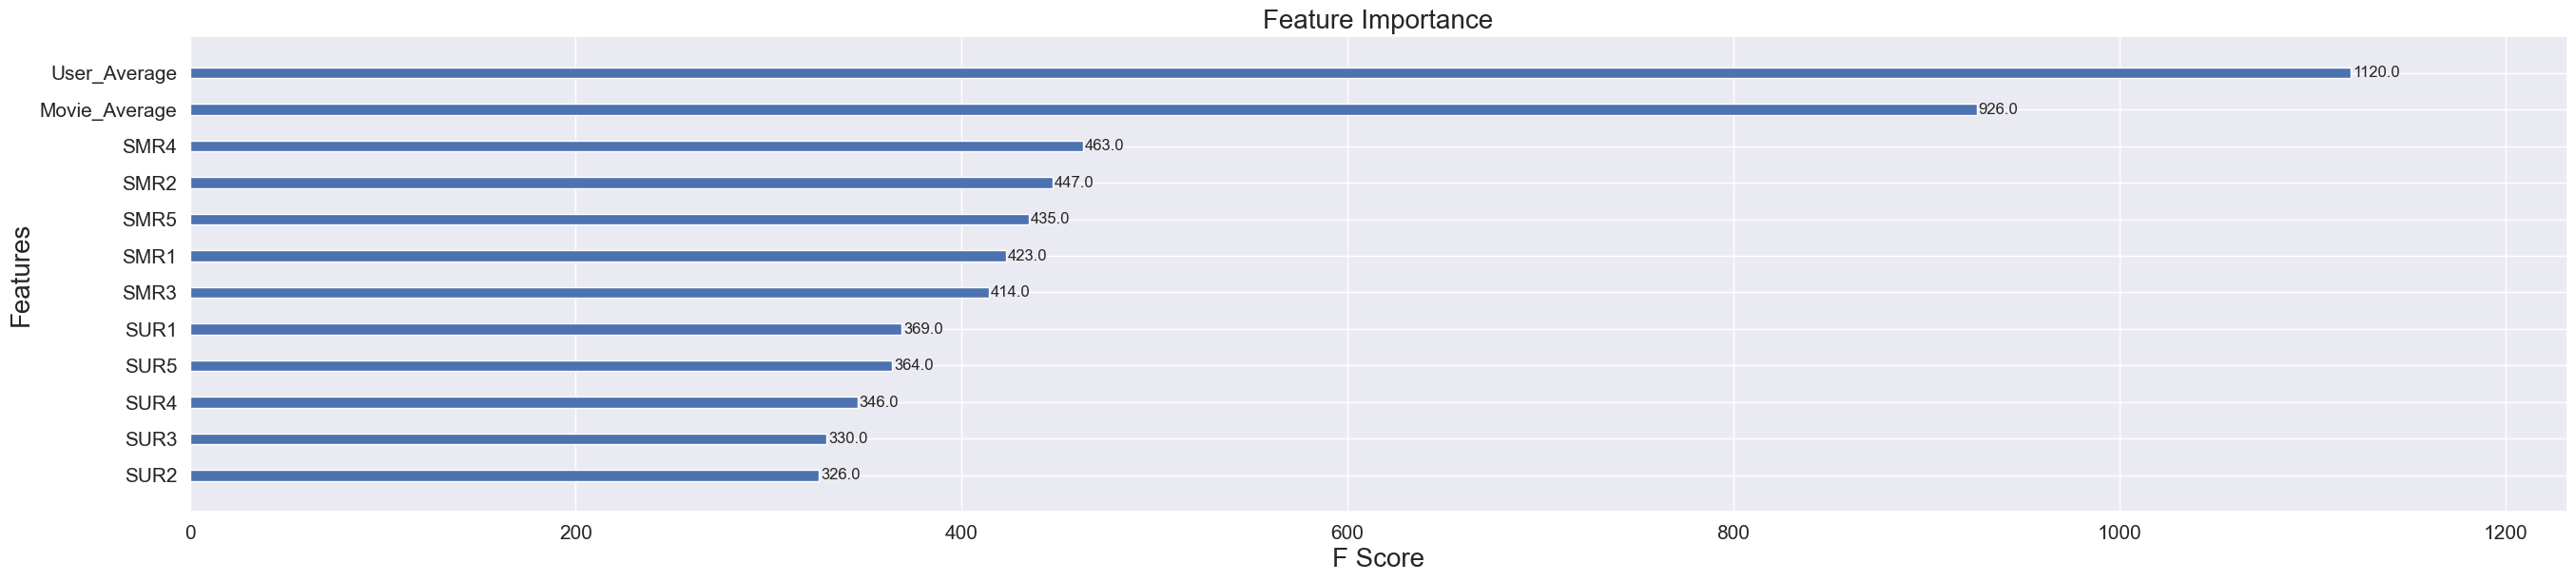

In [92]:
# Training the Xgboost Regression Model on with the 13 features

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

In [93]:
# Applying BaselineOnly from the surprise library to predict the ratings

bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8259045077604161
MAPE = 27.49617857716931
--------------------------------------------------
TEST DATA
RMSE = 0.99957947564343
MAPE = 36.46801865595947
--------------------------------------------------
Time Taken = 0:00:01.322323


In [94]:
# Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

train_regression_data["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]
test_regression_data["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]

In [95]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,34,140,3.5,4.0,3.525107,4.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,5.0,3.0,4.0,4.017986
1,34,185,3.5,4.0,2.967161,5.0,4.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0,4.0,3.0,3.515016
2,34,207,3.5,4.0,2.831174,4.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,5.0,3.483033
3,34,287,3.5,4.0,3.358491,5.0,4.0,4.0,3.0,1.0,3.0,5.0,4.0,3.0,4.0,4.0,3.887365
4,34,491,3.5,4.0,3.387127,5.0,5.0,5.0,2.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0,4.058829


In [96]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,133,1235,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.5,3.496708
1,133,5891,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708
2,133,8102,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708
3,133,19090,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708
4,285,17284,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708


--------------------------------------------------
TRAIN DATA
RMSE : 0.6890196987627143
MAPE : 21.38563969838684
--------------------------------------------------
TEST DATA
RMSE : 1.0342838440281363
MAPE : 36.58375113319952
--------------------------------------------------
Time Taken :  0:00:01.780204


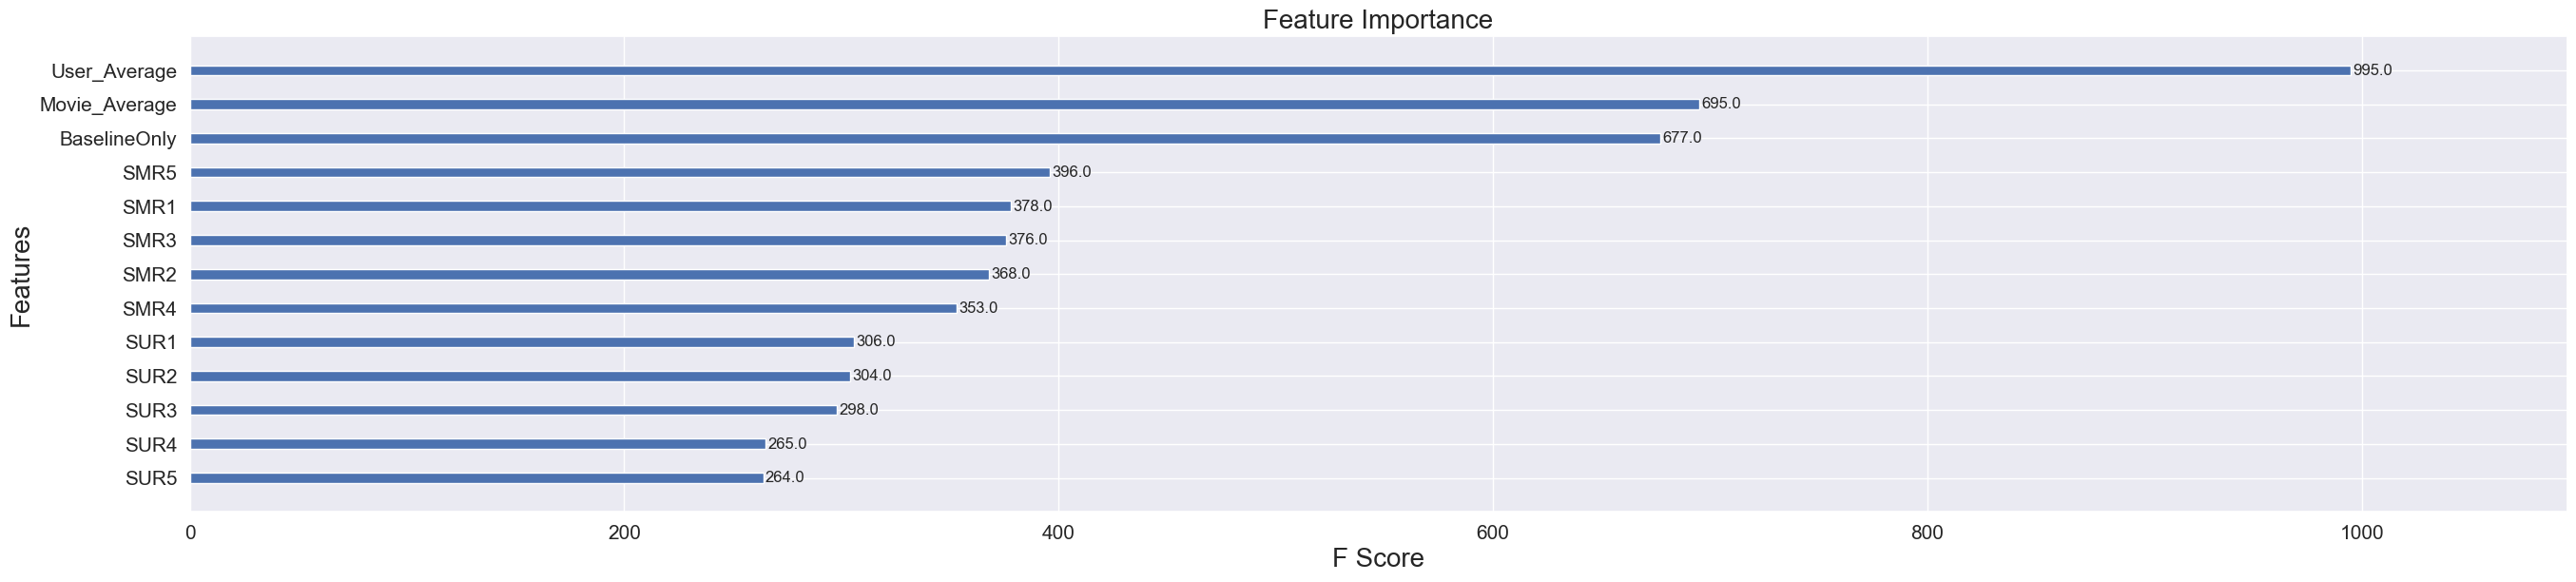

In [97]:
# Fitting the Xgboost again with new BaselineOnly feature

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

In [98]:
# Finding the suitable parameter for Surprise KNN-Baseline with User-User Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [99]:
# Applying the KNN-Baseline with the searched parameters

sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3345163322170381
MAPE = 10.189871748001222
--------------------------------------------------
TEST DATA
RMSE = 0.9994800764000862
MAPE = 36.4607597007297
--------------------------------------------------
Time Taken = 0:00:48.282636


In [100]:
# Similarly finding best parameters for Surprise KNN-Baseline with Item-Item Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [101]:
# Applying KNN-Baseline with best parameters searched

sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.2729372731256783
MAPE = 7.949693757355172
--------------------------------------------------
TEST DATA
RMSE = 0.9994800764000862
MAPE = 36.4607597007297
--------------------------------------------------
Time Taken = 0:00:10.845093


In [102]:
# Addding the KNNBaseline features to the train and test dataset

train_regression_data["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
train_regression_data["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

test_regression_data["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
test_regression_data["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [103]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,133,1235,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.5,3.496708,3.496708,3.496708
1,133,5891,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708,3.496708,3.496708
2,133,8102,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708,3.496708,3.496708
3,133,19090,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708,3.496708,3.496708
4,285,17284,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708,3.496708,3.496708


--------------------------------------------------
TRAIN DATA
RMSE : 0.12183314156298834
MAPE : 2.8186556160932876
--------------------------------------------------
TEST DATA
RMSE : 0.9996370380165323
MAPE : 36.45305450216557
--------------------------------------------------
Time Taken :  0:00:01.889943


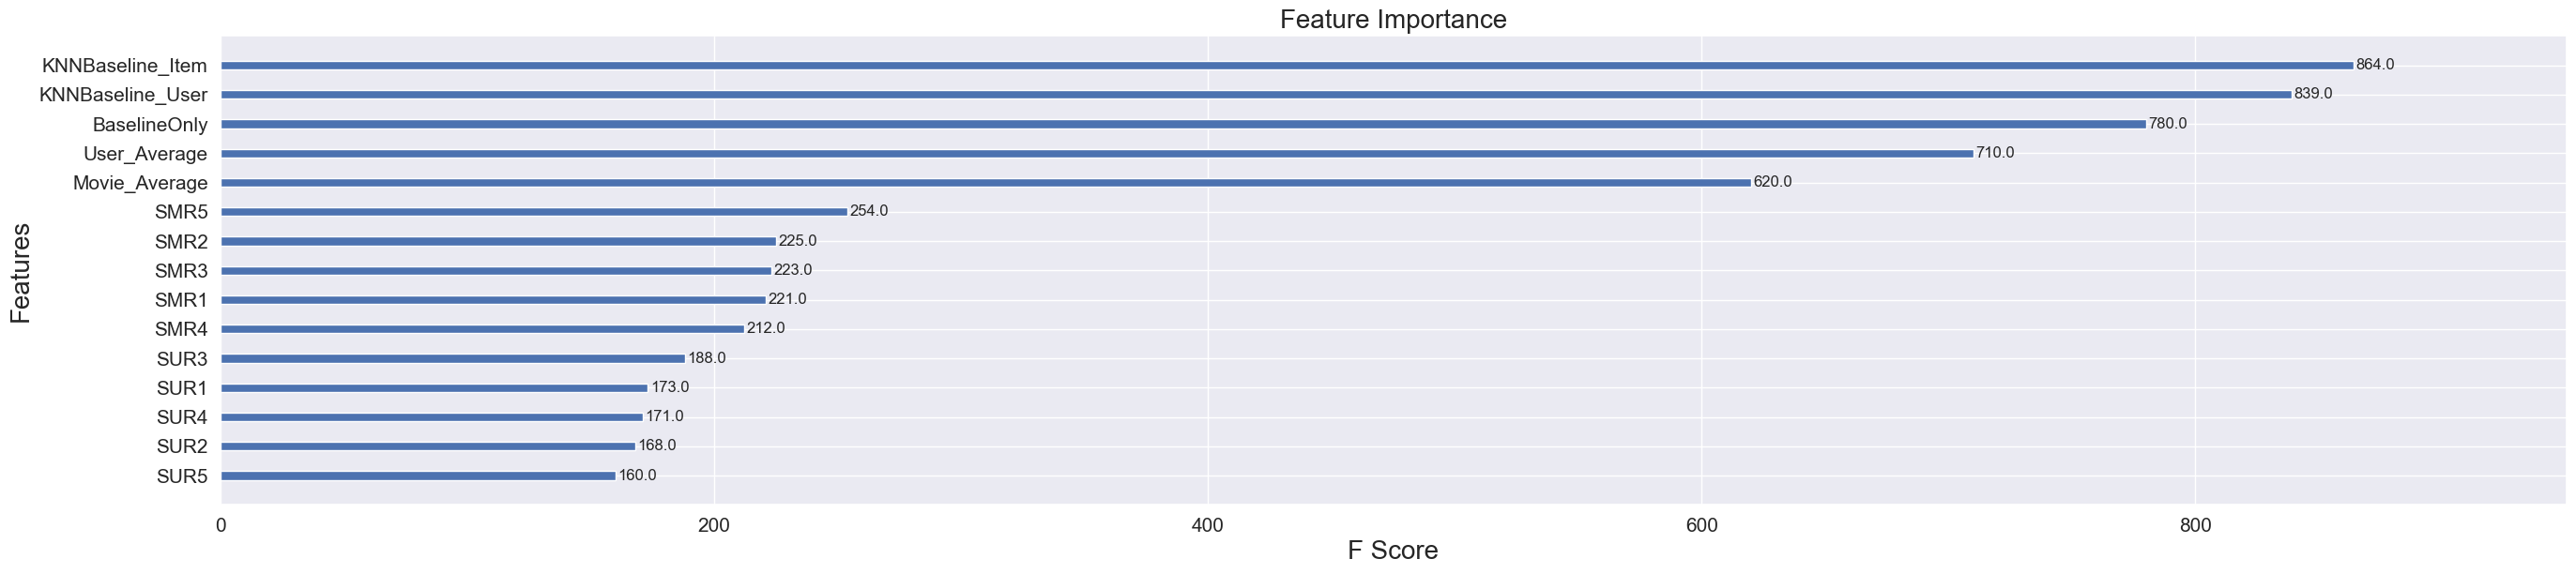

In [104]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

In [105]:
# Appling the SlopeOne algorithm from the Surprise library

so = SlopeOne()

train_result, test_result = run_surprise(so, trainset, testset, "SlopeOne")

model_train_evaluation["SlopeOne"] = train_result
model_test_evaluation["SlopeOne"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE = 0.7605719565534241
MAPE = 24.411323730221813
--------------------------------------------------
TEST DATA
RMSE = 0.9991458413459061
MAPE = 36.447592340762306
--------------------------------------------------
Time Taken = 0:00:02.939553


In [106]:
# Adding the SlopOne predictions to the train and test datasets

train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]
train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]

test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]
test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]

In [107]:
# Matrix Factorization using SVD from Surprise Library

# here, n_factors is the equivalent to dimension 'd' when matrix 'A'
# is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9029404844721131
{'n_factors': 5}


In [108]:
# Applying SVD with best parameters

algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8315783802849384
MAPE = 28.07541400105463
--------------------------------------------------
TEST DATA
RMSE = 0.9994838615815167
MAPE = 36.46081452294064
--------------------------------------------------
Time Taken = 0:00:02.781195


In [109]:
# Matrix Factorization SVDpp with implicit feedback

# Hyper-parameter optimization for SVDpp
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8967072704177689
{'n_factors': 10, 'lr_all': 0.006}


In [110]:
#Applying SVDpp with best parameters¶

algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7647598095993936
MAPE = 25.439154541562946
--------------------------------------------------
TEST DATA
RMSE = 0.9995319440578992
MAPE = 36.4609379870524
--------------------------------------------------
Time Taken = 0:00:08.021646


In [111]:
# XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

train_regression_data["SVD"] = model_train_evaluation["SVD"]["Prediction"]
train_regression_data["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

test_regression_data["SVD"] = model_test_evaluation["SVD"]["Prediction"]
test_regression_data["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [112]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVD,SVDpp
0,34,140,3.5,4.0,3.525107,4.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,5.0,3.0,4.0,4.017986,3.963135,4.010442,4.220130,3.833850,3.980470
1,34,185,3.5,4.0,2.967161,5.0,4.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0,4.0,3.0,3.515016,3.140596,3.055667,3.718481,3.326672,3.643529
2,34,207,3.5,4.0,2.831174,4.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,4.0,5.0,3.483033,4.423393,4.864125,3.561952,3.235565,3.447948
3,34,287,3.5,4.0,3.358491,5.0,4.0,4.0,3.0,1.0,3.0,5.0,4.0,3.0,4.0,4.0,3.887365,3.878831,3.908286,3.892439,3.701821,3.798214
4,34,491,3.5,4.0,3.387127,5.0,5.0,5.0,2.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0,4.058829,3.951408,4.115291,4.100594,3.828089,3.865983


In [113]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVD,SVDpp
0,133,1235,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.5,3.496708,3.496708,3.496708,3.496708,3.496708,3.496708
1,133,5891,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708,3.496708,3.496708,3.496708,3.496708,3.496708
2,133,8102,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708,3.496708,3.496708,3.496708,3.496708,3.496708
3,133,19090,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,4.0,3.496708,3.496708,3.496708,3.496708,3.496708,3.496708
4,285,17284,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,5.0,3.496708,3.496708,3.496708,3.496708,3.496708,3.496708


--------------------------------------------------
TRAIN DATA
RMSE : 0.11479380898450504
MAPE : 2.645956613840028
--------------------------------------------------
TEST DATA
RMSE : 0.99880813942446
MAPE : 36.49226983349222
--------------------------------------------------
Time Taken :  0:00:02.539872


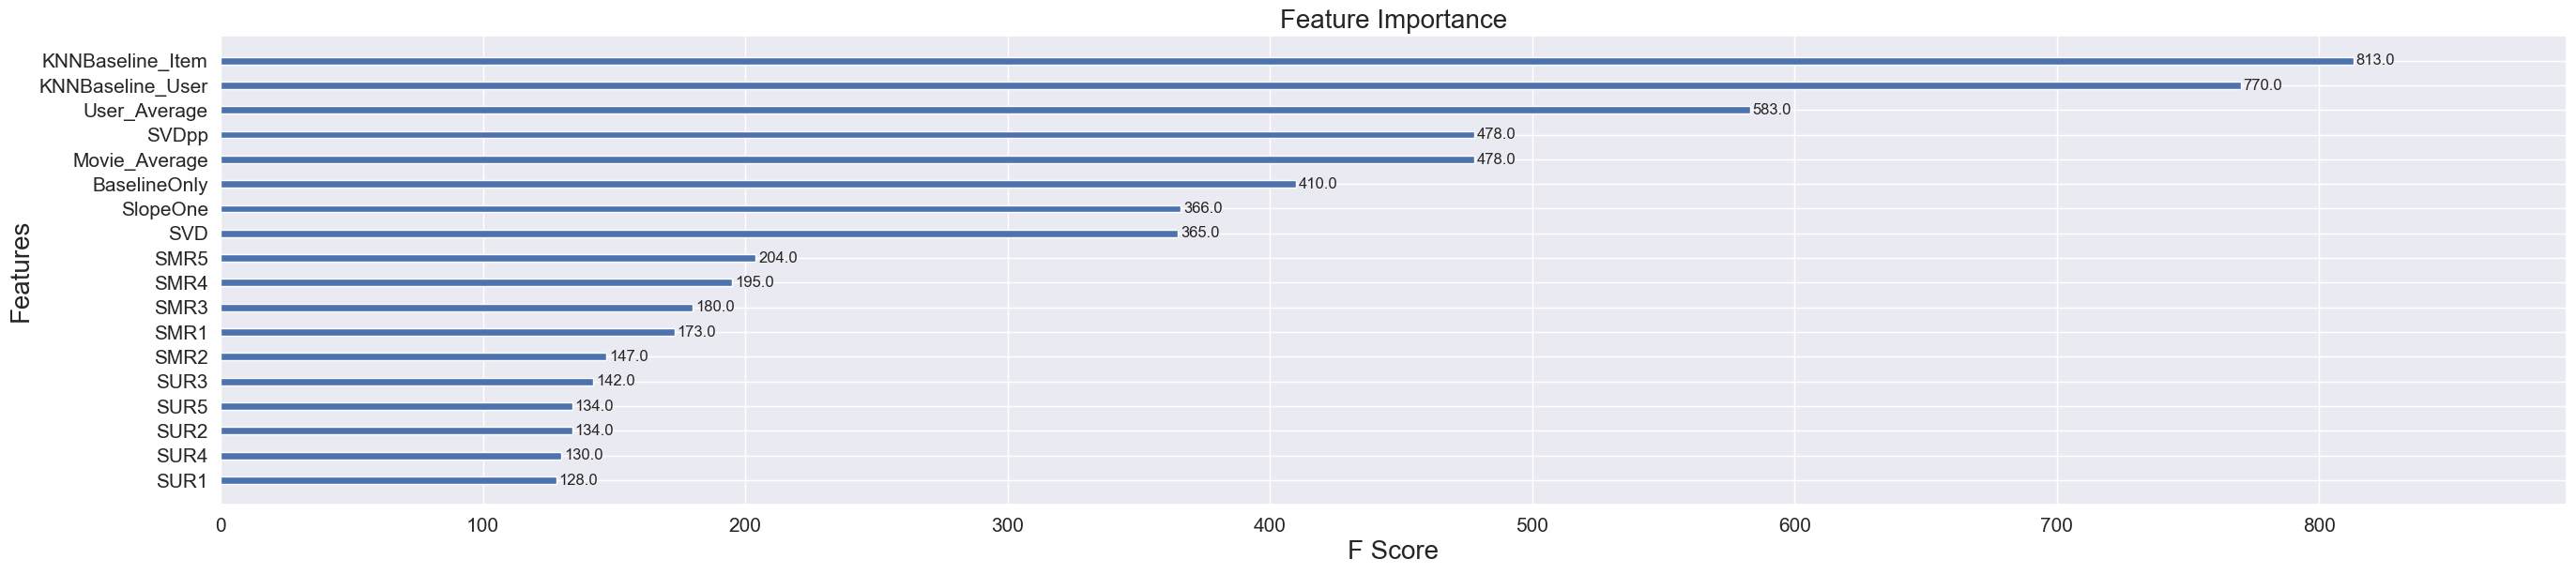

In [114]:
# Applying Xgboost on the feature set

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE : 0.1266209781758926
MAPE : 2.9548050271284136
--------------------------------------------------
TEST DATA
RMSE : 0.9984094185065601
MAPE : 36.55035699635614
--------------------------------------------------
Time Taken :  0:00:01.659361


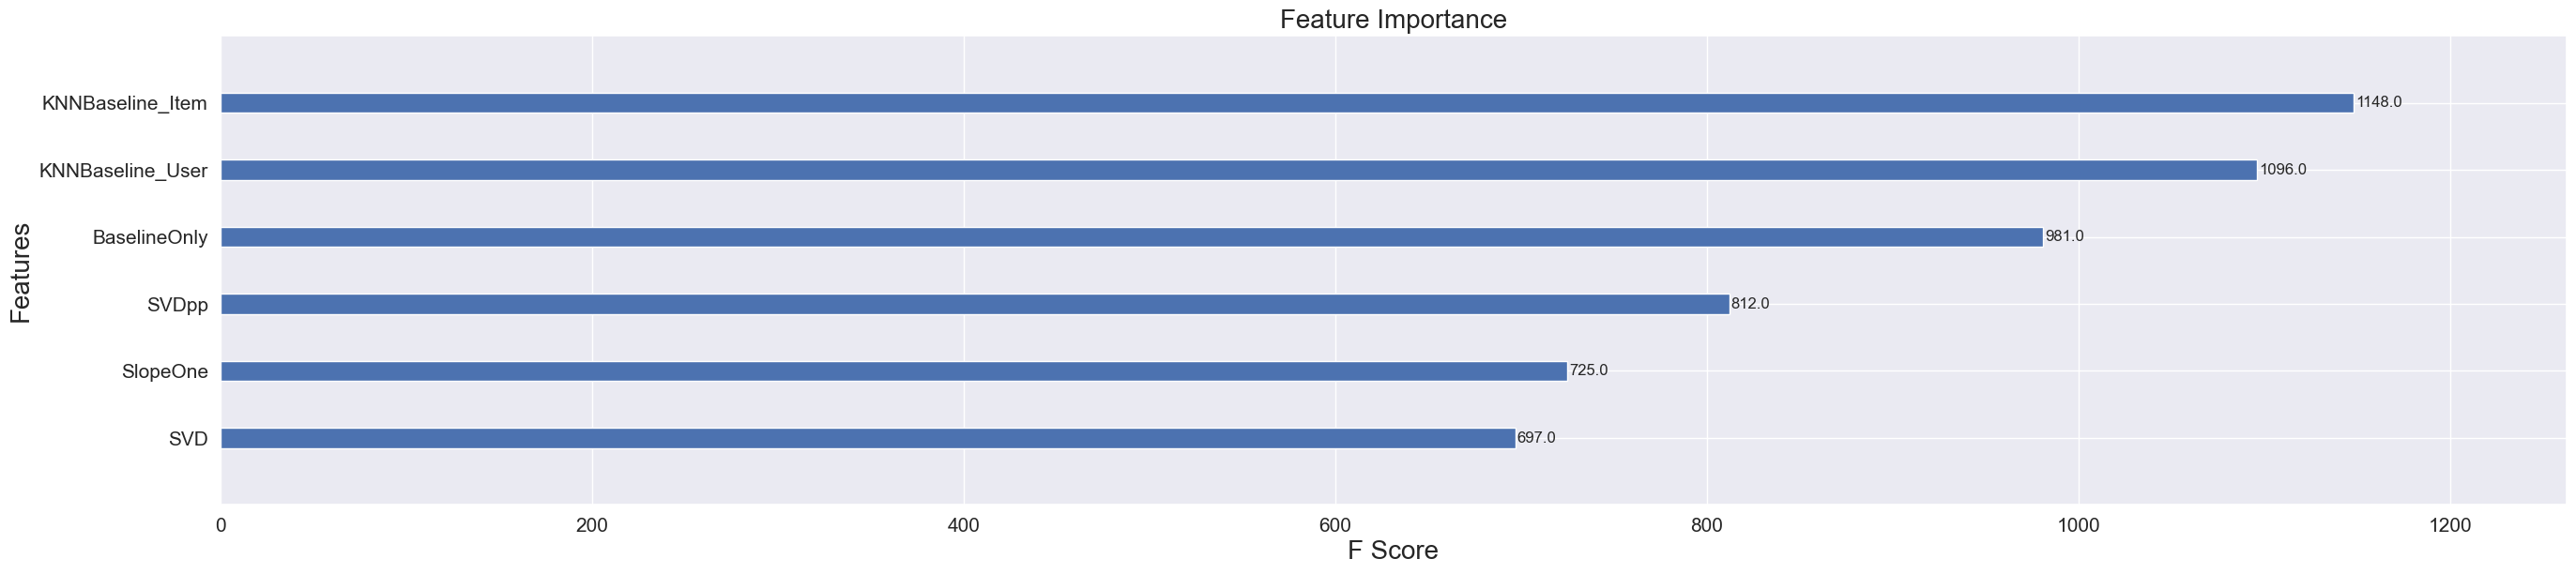

In [115]:
# Applying Xgboost with Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne

x_train = train_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]
x_test = test_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF_SO")

model_train_evaluation["XGB_KNN_MF_SO"] = train_result
model_test_evaluation["XGB_KNN_MF_SO"] = test_result

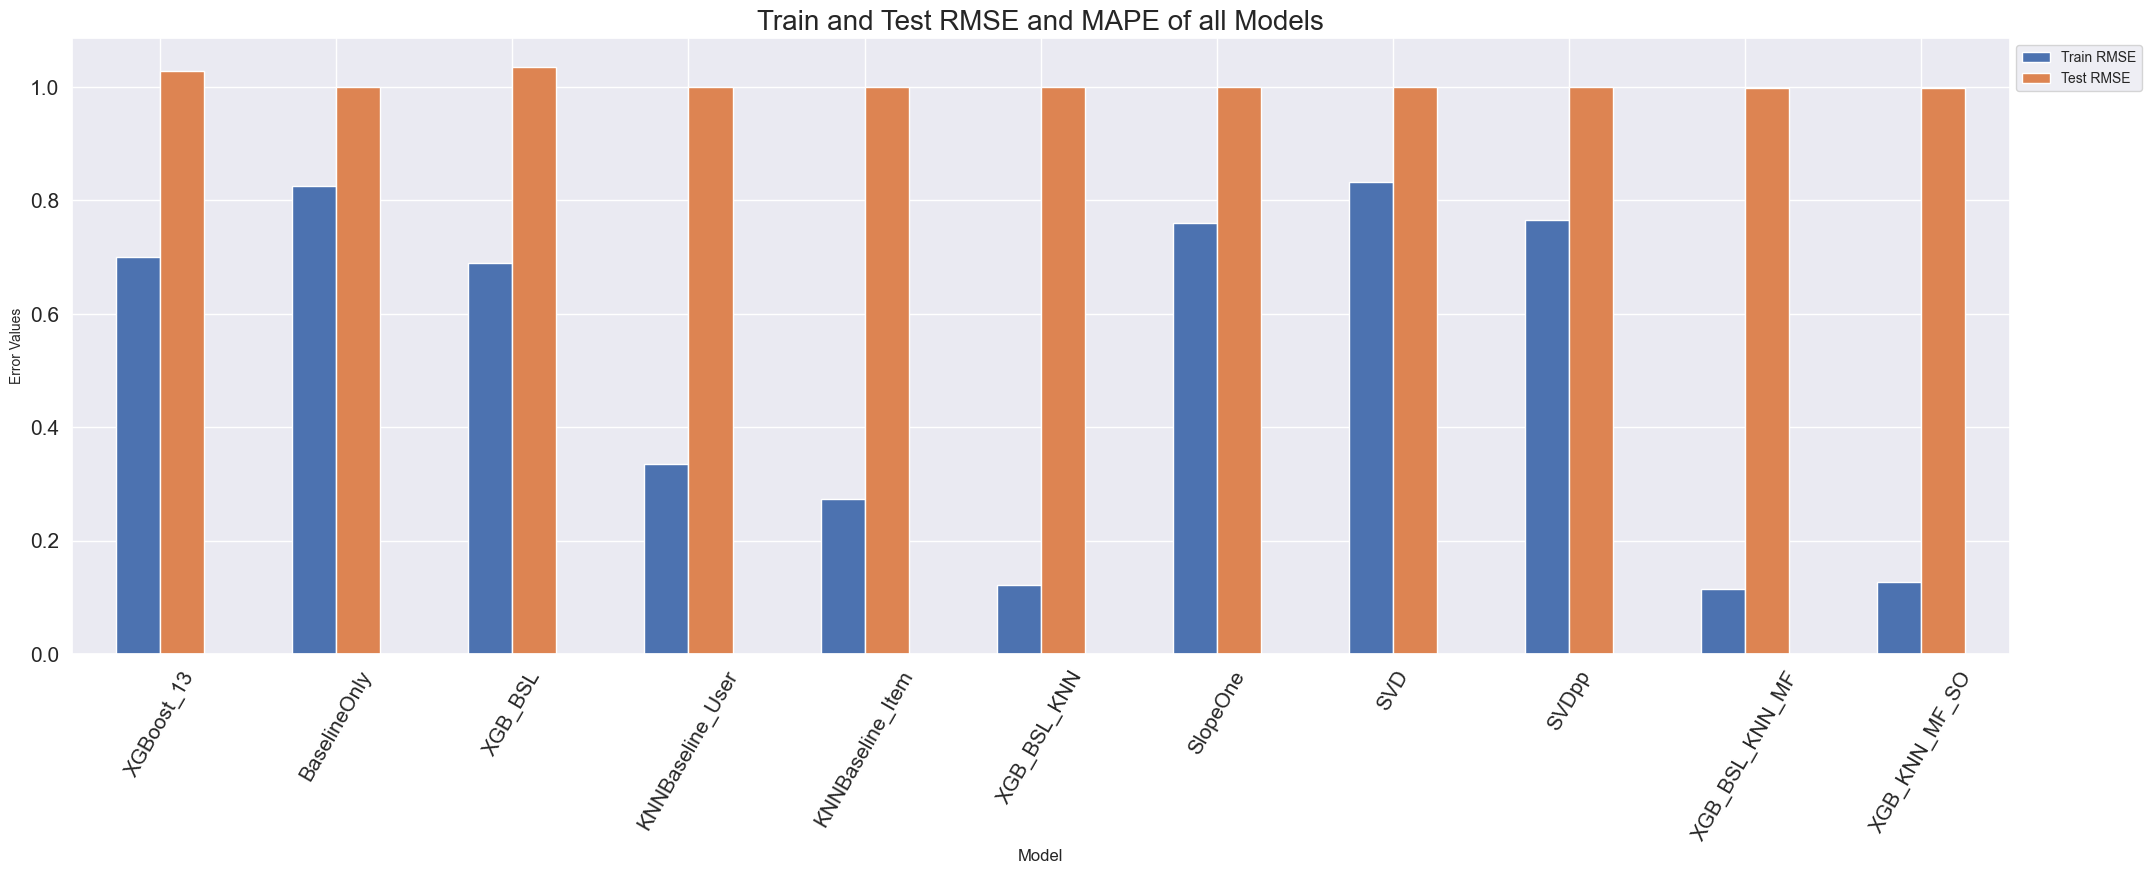

In [116]:
# Visualizing the errors of all the models we tested out

error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (25, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 10)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 10)
plt.show()

In [117]:
# Tabular Values of Errors

error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.700831,1.027542
1,BaselineOnly,0.825905,0.999579
2,XGB_BSL,0.689020,1.034284
3,KNNBaseline_User,0.334516,0.999480
4,KNNBaseline_Item,0.272937,0.999480
5,XGB_BSL_KNN,0.121833,0.999637
6,SlopeOne,0.760572,0.999146
7,SVD,0.831578,0.999484
8,SVDpp,0.764760,0.999532
9,XGB_BSL_KNN_MF,0.114794,0.998808


In [118]:
# Testing the recommendations made by SVDpp Algorithm

from collections import defaultdict

def Get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, mid, true_r, est, _ in predictions:
        top_n[uid].append((mid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [119]:
# Creating instance of svd_pp

svd_pp = SVDpp(n_factors = 10, lr_all = 0.006, verbose=True)
svd_pp.fit(trainset)
predictions = svd_pp.test(testset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


In [120]:
# Saving the training predictions

train_pred = svd_pp.test(trainset.build_anti_testset())
top_n = Get_top_n(train_pred, n=10)

### 4.3 Generating Recommendation for Users
I am using SVDpp to generate atmost 10 recommendated movies for various users.

In [121]:
# Print the recommended items for each user

def Generate_Recommendated_Movies(u_id, n=10):

    recommend = pd.DataFrame(top_n[u_id], columns=["Movie_Id", "Predicted_Rating"])
    recommend = recommend.merge(movies, how="inner", left_on="Movie_Id", right_on="movieId")
    recommend = recommend[["Movie_Id", "title", "genres", "Predicted_Rating"]]

    return recommend[:n]

In [122]:
# Saving the sampled user id list to help generate movies

sampled_user_id = list(top_n.keys())

In [123]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  49779


,Movie_Id,title,genres,Predicted_Rating
0,5918,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.461342
1,2850,"Lady Eve, The (1941)",Comedy|Romance,4.450591
2,213,Before the Rain (Pred dozhdot) (1994),Drama|War,4.418346
3,1733,Fireworks (Hana-bi) (1997),Crime|Drama,4.315076
4,1184,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.307178
5,7045,Fog of War: Eleven Lessons from the Life of Ro...,Documentary|War,4.306747
6,3380,"Hustler, The (1961)",Drama,4.297514
7,9696,"Downfall (Untergang, Der) (2004)",Drama|War,4.270766
8,3005,Kagemusha (1980),Drama|War,4.264269
9,1208,"Sting, The (1973)",Comedy|Crime,4.258845


In [124]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  2621


,Movie_Id,title,genres,Predicted_Rating
0,316,"Shawshank Redemption, The (1994)",Crime|Drama,4.835329
1,5918,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.747387
2,2850,"Lady Eve, The (1941)",Comedy|Romance,4.577831
3,1733,Fireworks (Hana-bi) (1997),Crime|Drama,4.553889
4,1172,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.518924
5,213,Before the Rain (Pred dozhdot) (1994),Drama|War,4.507178
6,3380,"Hustler, The (1961)",Drama,4.494068
7,3005,Kagemusha (1980),Drama|War,4.468536
8,3711,Anatomy of a Murder (1959),Drama|Mystery,4.463626
9,1184,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.444808


In [125]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  121289


,Movie_Id,title,genres,Predicted_Rating
0,5918,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.730010
1,316,"Shawshank Redemption, The (1994)",Crime|Drama,4.671348
2,2850,"Lady Eve, The (1941)",Comedy|Romance,4.633514
3,213,Before the Rain (Pred dozhdot) (1994),Drama|War,4.585107
4,1184,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.510612
5,7045,Fog of War: Eleven Lessons from the Life of Ro...,Documentary|War,4.489268
6,1733,Fireworks (Hana-bi) (1997),Crime|Drama,4.481741
7,1172,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.477577
8,3380,"Hustler, The (1961)",Drama,4.470022
9,11355,"Pan's Labyrinth (Laberinto del fauno, El) (2006)",Drama|Fantasy|Thriller,4.448595


In [126]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  7659


,Movie_Id,title,genres,Predicted_Rating
0,5918,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.826910
1,2850,"Lady Eve, The (1941)",Comedy|Romance,4.717949
2,213,Before the Rain (Pred dozhdot) (1994),Drama|War,4.678540
3,1733,Fireworks (Hana-bi) (1997),Crime|Drama,4.670873
4,3380,"Hustler, The (1961)",Drama,4.602523
5,3711,Anatomy of a Murder (1959),Drama|Mystery,4.576566
6,3005,Kagemusha (1980),Drama|War,4.570283
7,7045,Fog of War: Eleven Lessons from the Life of Ro...,Documentary|War,4.565879
8,9696,"Downfall (Untergang, Der) (2004)",Drama|War,4.556519
9,1184,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.551252
